In [59]:
import polars as pl
import pandas as pd
import numpy as np
import cvxpy as cp

import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.ticker as ticker

from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

In [60]:
# Contains needed functions for the work

def matrix_inversion_bootstrap(prices, cashflows):
    """
    Bootstrap zero-coupon bond prices using matrix inversion.
    
    We have: P^C = CF * P^Z
    Therefore: P^Z = CF^{-1} * P^C
    """
    # Invert the cashflow matrix
    cf_inverse = np.linalg.inv(cashflows)
    
    # Calculate zero-coupon prices
    zero_prices = cf_inverse @ prices
    
    return zero_prices

def calculate_bond_price(bond_yield, coupon_frequency, maturities, cashflows, numeric=False):
    """
    Calculate Bond Price by using bond yield 

    bond_yield: yield by maturity 
    coupon_frequency: frequency of coupon
    maturities: maturity of different bonds 
    cashflows: matrix of bond cashflows
    numeric: bolean (True if bond_yield numeric, False if bond_yield (%))
    """
    if numeric == False:
        standardized_bond_yield = bond_yield / 100
        discount_factor = 1.0 / ( 1.0 + (standardized_bond_yield / coupon_frequency)) ** (maturities * coupon_frequency)
        bond_price = cashflows @ discount_factor
        
    else:
        standardized_bond_yield = bond_yield
        discount_factor = 1.0 / ( 1.0 + (standardized_bond_yield / coupon_frequency)) ** (maturities * coupon_frequency)
        bond_price = cashflows @ discount_factor

    return np.round(bond_price, 4)

def cubic_spline(X_data:np.array, Y_data:np.array, custom_knots:np.array):
    """
    X_data: Maturity in an array
    Y_data: Zero Coupon Yields in an array
    known_discount_factors: Know discount factor in an array
    customm_knots: Array of chosen knots

    return: X_smooth, Y_smooth, r2
    """

    # Define custom knot locations (interior knots only)
    # Reshape x_data for sklearn (needs 2D input)
    custom_knots = custom_knots.reshape(-1, 1)

    # Create SplineTransformer with custom knots
    spline = SplineTransformer(
        degree=3,                   # Cubic splines
        knots=custom_knots,         # Our custom knot locations
        include_bias=False,         # Let LinearRegression handle the intercept
        extrapolation='continue'    # Spline extrapolation outside the knot range
        )

    # Reshape x_data for sklearn (needs 2D input)
    X = X_data.reshape(-1,1)

    # Fit and transform the data
    X_spline = spline.fit_transform(X)

    # Fit linear regression on the spline basis
    model = LinearRegression()
    model.fit(X_spline, Y_data)

    # Calculate R-squared
    r2 = r2_score(Y_data, model.predict(X_spline))

    # Create fine grid and ensure original maturities are included (unique, sorted)
    X_smooth = np.linspace(X_data.min(), X_data.max(), 200)
    X_smooth = np.union1d(X_smooth, X_data).reshape(-1, 1)

    # Generate smooth curve for visualization
    X_smooth_spline = spline.transform(X_smooth)
    Y_smooth = model.predict(X_smooth_spline)

    return X_smooth, Y_smooth, r2


def yield_curve_model(tau, beta0, beta1, beta2, beta3, lambda1, lambda2):
    """
    Unified Nelson-Siegel-Svensson model for spot rates.
    
    Parameters:
    -----------
    tau : array-like
        Time to maturity
    beta0, beta1, beta2, beta3 : float
        Core model parameters
    lambda1, lambda2 : float
        First decay parameter
        
    Returns:
    --------
    array-like : Fitted rates
    """
    tau_over_lambda1 = tau / lambda1
    exp_term1 = np.exp(-tau_over_lambda1)
    
    # Core Nelson-Siegel terms
    term1 = (1 - exp_term1) / tau_over_lambda1
    term2 = term1 - exp_term1
    rates = beta0 + beta1 * term1 + beta2 * term2
    
    # Add Svensson extension
    tau_over_lambda2 = tau / lambda2
    exp_term2 = np.exp(-tau_over_lambda2)
    term3 = (1 - exp_term2) / tau_over_lambda2 - exp_term2
    rates += beta3 * term3
    
    return rates

def calibrate_yield_curve(maturities, rates):
    """
    Unified calibration function for Nelson-Siegel-Svensson models.
    
    Parameters:
    -----------
    maturities : array-like
        Time to maturity for each rate
    rates : array-like
        Market rates (spot or forward depending on rate_type)
        
    Returns:
    --------
    dict : Calibration results including parameters, fit statistics
    """
    def objective(params):
        beta0, beta1, beta2, beta3, lambda1, lambda2 = params
        fitted = yield_curve_model(maturities, beta0, beta1, beta2, beta3, lambda1, lambda2)
        return np.sum((fitted - rates)**2)

    beta0_init = rates[-1]
    beta1_init = rates[0] - rates[-1]
    medium_idx = np.argmin(np.abs(maturities - 2.5))
    beta2_init = 2 * rates[medium_idx] - rates[0] - rates[-1]
    
    # beta3: smaller magnitude than beta2 (ECB empirical findings)
    beta3_init = beta2_init * 0.5

    bounds = [
    # beta0: ECB operational bounds [0, 0.10]
    # Extended to 0.15 for extreme market conditions
    (0, 0.15),      
    
    # beta1: ECB [-0.10, 0.10], ensures beta0 + beta1 > 0
    # Critical for positive short rates (Fed FEDS 2006/28)
    (-0.15, 0.15),  
    
    # beta2: ECB standard [-0.10, 0.10]
    # Wider bounds reduce parameter instability (Optimization Online 2024)
    (-0.30, 0.30),  

    # beta3: ECB [-0.10, 0.10]
    # Often smaller magnitude than beta2 (ECB Statistics Paper 27)
    (-0.15, 0.15),  
    
    # lambda1: ECB [0.1, 4.0]
    # Most empirical estimates fall in [0.5, 2.5] (Multiple central bank studies)
    (0.1, 4.0),      
    
    # lambda2: ECB [4.0, 30.0], must satisfy lambda2 > lambda1
    # Most empirical estimates 5-20 (ECB operational data)
    # Upper bound 30 prevents numerical issues (Bank of Canada TR 84)
    (4.0, 30.0)     
    ]
    
    # lambda1: short-medium term factor (2-3 years typical)
    # lambda2: long term factor (8-10 years typical)
    # Bank of Canada and ECB empirical studies
    x0 = [beta0_init, beta1_init, beta2_init, beta3_init, 1.5, 5.0]

    # Additional constraints for economic interpretation
    # Ensure positive short rates: beta0 + beta1 > 0
    # This is a minimum requirement across all central bank implementations
    def constraint_positive_short_rate(params):
        return params[0] + params[1]  # beta0 + beta1 > 0
    
    # For Svensson: ensure lambda2 > lambda1 for factor identification
    # Critical requirement (ECB, Fed, Bank of Canada)
    def constraint_lambda_ordering(params):
        return params[5] - params[4] - 0.1  # lambda2 - lambda1 > 0.1
    
    constraints = [
        {'type': 'ineq', 'fun': constraint_positive_short_rate},
        {'type': 'ineq', 'fun': constraint_lambda_ordering}
        ]
    
    # Optimization with multi-start procedure
    # Bank of Canada uses 100+ random starts to avoid local minima
    # Using L-BFGS-B as primary optimizer (standard in central bank implementations)
    # Consider differential evolution for global search (Gilli et al. 2010)
    result = minimize(
        objective, 
        x0, 
        bounds=bounds, 
        constraints=constraints,
        method='L-BFGS-B',
        options={
            'maxiter': 1000,  # Increased iterations for complex surfaces
            'ftol': 1e-10     # Tighter tolerance (ECB specification)
        }
    )
    
    # Check for parameter stability
    # Condition number > 10 indicates multicollinearity (Ridge regression paper 2013)
    # Consider implementing ridge penalty if instability detected
    
    # Prepare return dictionary
    return {
            'model': 'Svensson',
            'beta0': result.x[0],
            'beta1': result.x[1],
            'beta2': result.x[2],
            'beta3': result.x[3],
            'lambda1': result.x[4],
            'lambda2': result.x[5],
            'success': result.success,
            'sse': result.fun,
            'rmse': np.sqrt(result.fun / len(maturities)),
            'n_params': 6,
            'convergence_message': result.message
            }



<font color='red' size=8>QUESTION 1 - Bootstrapping</font>


<font color='lightgreen' size=5> Q1.1: Solve for the prices of discount bonds given the market prices of coupon bonds and identify the zero-coupon yields from the prices of zero-coupon bonds.</font>

In [61]:
raw_data = pl.read_excel("XLS698-XLS-ENG.xls", sheet_name="Exhibit 1")

col = [str(c).strip('"') for c in raw_data.row(0)]

data = raw_data.slice(1).rename(dict(zip(raw_data.columns, col)))

data = data.filter(
    pl.col("Coupon Rate (%)")
    .str.strip_chars()
    .cast(pl.Float64, strict=False)
    .is_not_null()
    )

data = data.with_columns([
    pl.col("Coupon Rate (%)").cast(pl.Float64, strict=False),
    pl.col("Maturity Date").str.strptime(pl.Date, "%m/%d/%Y", strict=False),
    pl.col("Current Price").cast(pl.Float64, strict=False)]
    )

data = data.sort(by="Maturity Date")

# Defining the reference date
ref_date = dt.datetime(2003, 8, 15).date() #provided in the Harvard Case

In [62]:
# Standardizing dates for sake of simplicity
data = data.with_columns(
    ((pl.col('Maturity Date') - ref_date).dt.total_days() / 365.25)
    .round(1)
    .alias('Maturity (years)')
    )

In [63]:
# Create cashflow matrix
n_bonds = len(data)
cashflows = np.zeros((n_bonds, n_bonds))

In [64]:
# Defining the frequency 
coupon_frequency = 2 # U.S. Treasury notes and bonds pay coupons semiannually (twice per year)
notianal = 100

coupon_value = (data.select(pl.col('Coupon Rate (%)')).to_numpy().reshape(-1) / 100) * notianal / coupon_frequency
bond_value = data.select(pl.col('Current Price')).to_numpy().reshape(-1)

for i in range(n_bonds):
    for j in range(i+1):
        if j < i: 
            cashflows[i,j] = coupon_value[i]
        else:
            cashflows[i,j] = notianal + coupon_value[i]
            break

In [65]:
zero_prices_matrix = matrix_inversion_bootstrap(bond_value, cashflows)

maturities_years = data.select(pl.col('Maturity (years)')).to_numpy().reshape(-1)
zero_rates = coupon_frequency * (zero_prices_matrix ** (-1.0 / (coupon_frequency * maturities_years)) - 1.0)

data = data.with_columns(
    [pl.lit(zero_prices_matrix).alias('Discount Factor'),
     pl.lit(zero_rates * 100).alias('Zero Coupon Yields (%)')]
    )

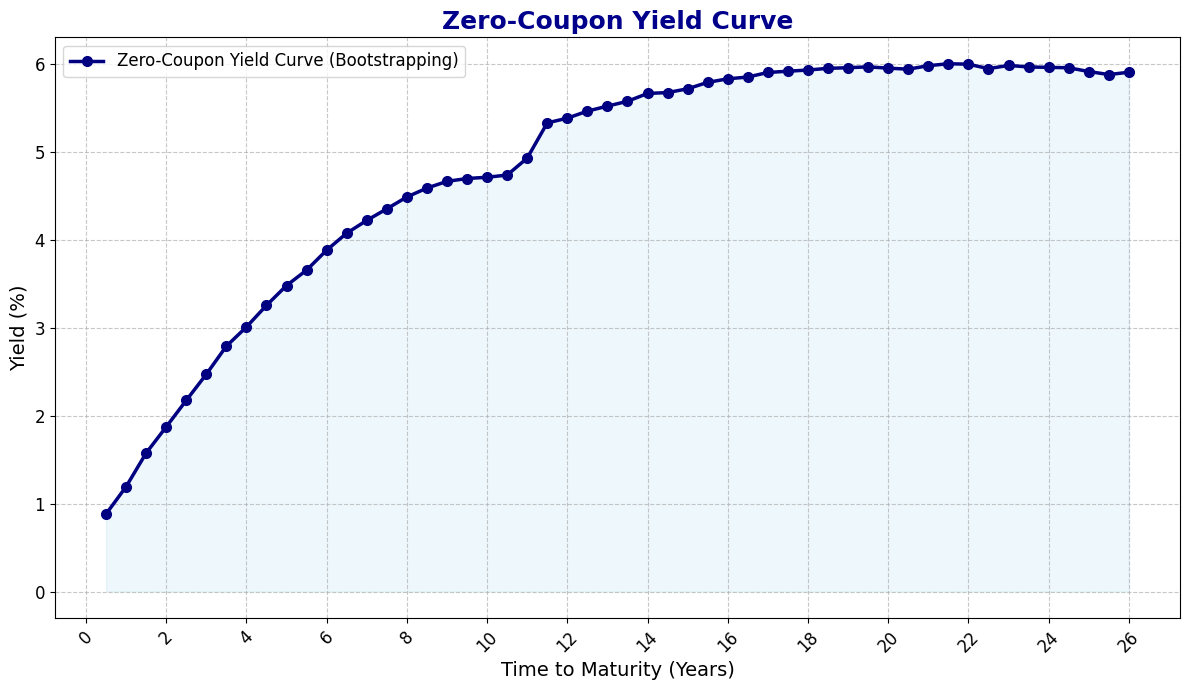

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(data['Maturity (years)'], 100 * zero_rates, 
         marker="o", linewidth=2.5, markersize=7, color="navy", label="Zero-Coupon Yield Curve (Bootstrapping)")

plt.fill_between(data['Maturity (years)'], 100 * zero_rates, alpha=0.15, color="skyblue")

plt.title("Zero-Coupon Yield Curve", fontsize=18, fontweight="bold", color="darkblue")
plt.xlabel("Time to Maturity (Years)", fontsize=14)
plt.ylabel("Yield (%)", fontsize=14)

plt.grid(True, linestyle="--", alpha=0.7)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


<font color='lightgreen' size=5> Q1.2: Compare the zero-coupon yields from Deutsche Bank's model (in Exhibit 4 of the case) to 
the  market  zero-coupon  yields,  and  identify  which  zero-coupon  bonds  Deutsche  Bank 
should buy, and which ones they should sell.</font>

In [67]:
raw_bank_data = pl.read_excel("XLS698-XLS-ENG.xls", sheet_name="Exhibit 4")

col = [str(c).strip('"') for c in raw_bank_data.row(0)]

bank_data = raw_bank_data.slice(1).rename(dict(zip(raw_bank_data.columns, col)))

bank_data = bank_data.filter(
    pl.col("Model Prediction (BEY)")
    .str.strip_chars('%')
    .is_not_null()
    )

bank_data = bank_data.with_columns([
    pl.col("Model Prediction (BEY)").str.strip_chars('%').cast(pl.Float64, strict=False),
    pl.col("Maturity (years)").str.strip_chars('y').cast(pl.Float64, strict=False)]
    )

merge_data = (data.join(bank_data, on='Maturity (years)')
              .drop(['Maturity Date', 'Current Price', 'Coupon Rate (%)'])
              )

merge_data_pd = pd.DataFrame(columns=[col for col in merge_data.columns], data=merge_data)

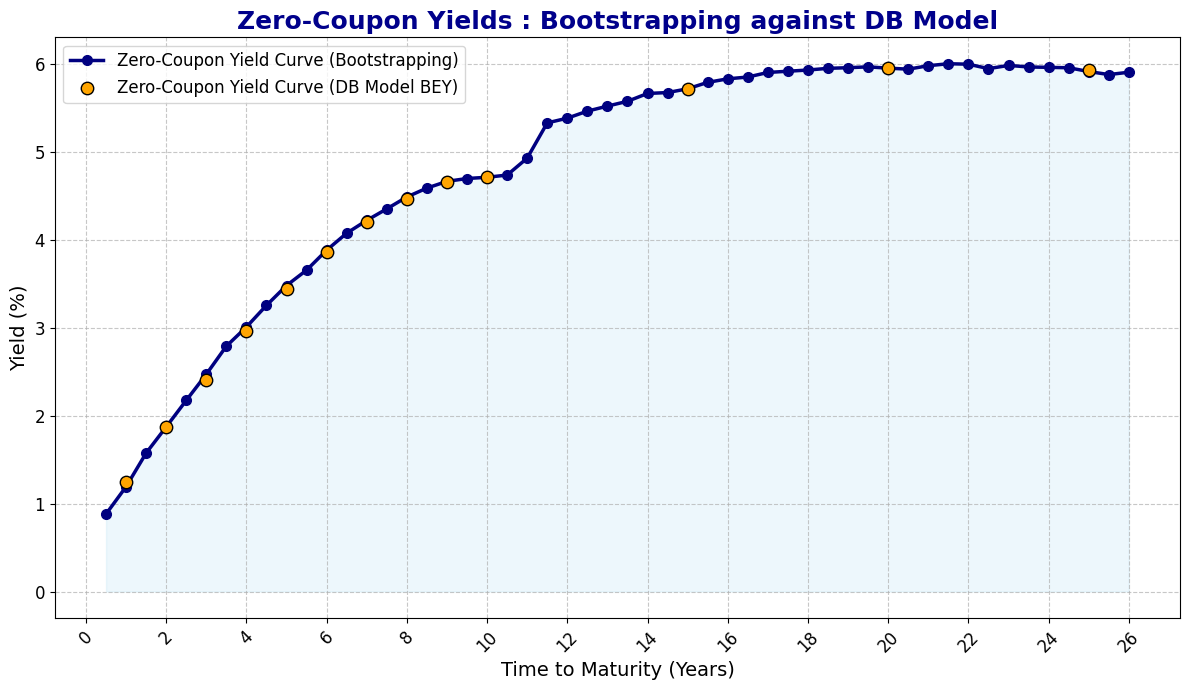

In [ ]:
plt.figure(figsize=(12,7))

plt.plot(data['Maturity (years)'], data['Zero Coupon Yields (%)'], 
         marker="o", linewidth=2.5, markersize=7, color="navy", label="Zero-Coupon Yield Curve (Bootstrapping)", zorder=2)

plt.fill_between(data['Maturity (years)'], data['Zero Coupon Yields (%)'], alpha=0.15, color="skyblue", zorder=1)

plt.scatter(merge_data_pd['Maturity (years)'], merge_data_pd['Model Prediction (BEY)'], 
            color="orange", s=80, edgecolor="black", label="Zero-Coupon Yield Curve (DB Model BEY)", zorder=3)

plt.title("Zero-Coupon Yields : Bootstrapping against DB Model", fontsize=18, fontweight="bold", color="darkblue")
plt.xlabel("Time to Maturity (Years)", fontsize=14)
plt.ylabel("Yield (%)", fontsize=14)

plt.grid(True, linestyle="--", alpha=0.7)

ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [69]:
merge_data_pd['Difference (bps)'] = (merge_data_pd['Zero Coupon Yields (%)'] - merge_data_pd['Model Prediction (BEY)']) * 100 
merge_data_pd

,Maturity (years),Discount Factor,Zero Coupon Yields (%),Model Prediction (BEY),Difference (bps)
0,1.0,0.988176,1.192962,1.2443,-5.133781
1,2.0,0.963406,1.872718,1.8727,0.001766
2,3.0,0.928970,2.471112,2.4110,6.011193
3,4.0,0.887418,3.008378,2.9665,4.187825
4,5.0,0.841559,3.479914,3.4454,3.451365
5,6.0,0.794000,3.881711,3.8557,2.601106
6,7.0,0.746507,4.220336,4.1996,2.073624
7,8.0,0.701204,4.486530,4.4677,1.883032
8,9.0,0.660381,4.663971,4.6528,1.117126
9,10.0,0.627754,4.710684,4.7107,-0.001643


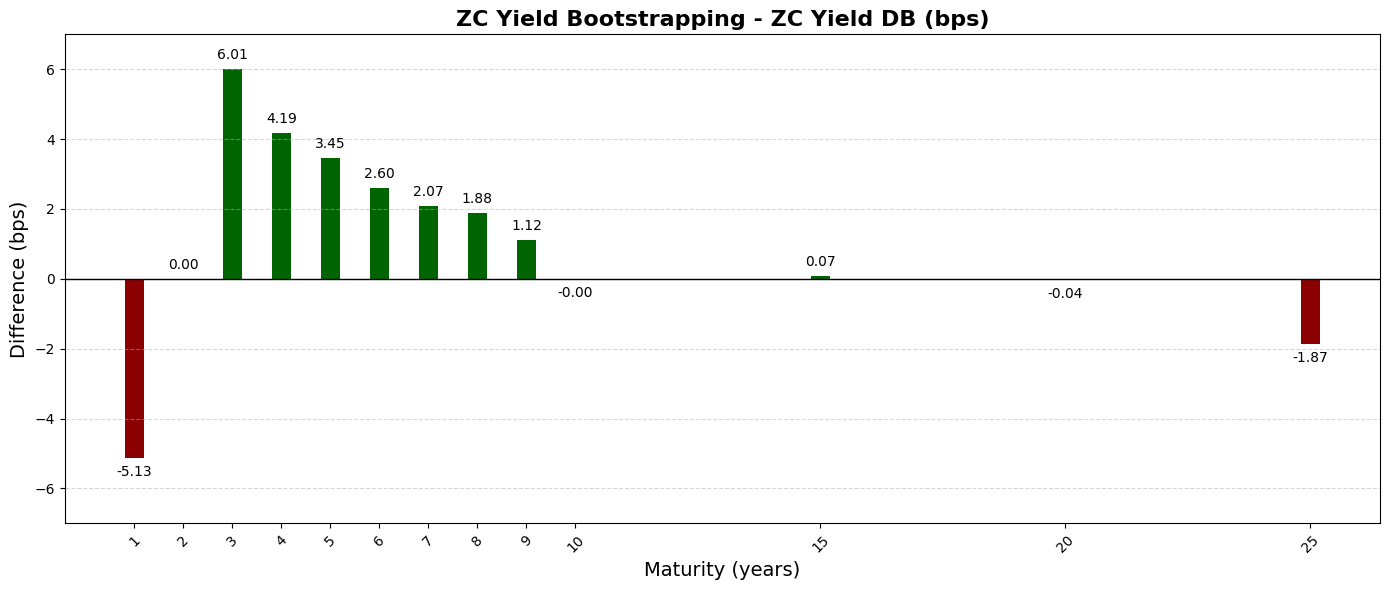

In [ ]:
plt.figure(figsize=(14,6))

colors = ["darkred" if x < 0 else "darkgreen" for x in merge_data_pd["Difference (bps)"]]

bars = plt.bar(merge_data_pd["Maturity (years)"], merge_data_pd["Difference (bps)"], color=colors, width=0.4)

plt.title("ZC Yield Bootstrapping - ZC Yield DB (bps)", fontsize=16, fontweight="bold")
plt.xlabel("Maturity (years)", fontsize=14)
plt.ylabel("Difference (bps)", fontsize=14)

plt.grid(True, linestyle="--", alpha=0.5, axis="y")
plt.axhline(0, color="black", linewidth=1)

plt.ylim(-7, 7)

plt.xticks(merge_data_pd["Maturity (years)"], rotation=45)

for bar, value in zip(bars, merge_data_pd["Difference (bps)"]):
    height = bar.get_height()
    if height >= 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2,  
                 f"{value:.2f}", ha="center", va="bottom", fontsize=10)
    else:
        plt.text(bar.get_x() + bar.get_width()/2, height - 0.2,
                 f"{value:.2f}", ha="center", va="top", fontsize=10)

plt.tight_layout()
plt.show()


### <font color='lightgreen' size=5>Q1.3: Is this strategy (of buying some bonds and selling others) a risk-free arbitrage strategy?

We should go <span style="color:green;font-weight:bold;">LONG</span> (resp. <span style="color:red;font-weight:bold;">SHORT</span>) an asset whenever the market price is <span style="color:green;font-weight:bold;">lower</span> (resp. <span style="color:red;font-weight:bold;">higher</span>) than what the model suggests the price should be.

In the previous analysis, the model suggests that:

- For maturities <span style="font-weight:bold;">1Y</span>, <span style="font-weight:bold;">20Y</span> and <span style="font-weight:bold;">25Y</span>, ZC_Yield_Market < ZC_Yield_Model : We should go <span style="color:green;font-weight:bold;">LONG</span> rate ⇒ <span style="color:red;font-weight:bold;">SHORT</span> bonds with maturities <span style="font-weight:bold;">1Y</span>, <span style="font-weight:bold;">20Y</span> and <span style="font-weight:bold;">25Y</span>.

- For maturities <span style="font-weight:bold;">2Y</span> and <span style="font-weight:bold;">10Y</span>, ZC_Yield_Market = ZC_Yield_Model : there is no preferred position.

- For maturities <span style="font-weight:bold;">3Y</span>, <span style="font-weight:bold;">4Y</span>, <span style="font-weight:bold;">5Y</span>, <span style="font-weight:bold;">6Y</span>, <span style="font-weight:bold;">7Y</span>, <span style="font-weight:bold;">8Y</span>, <span style="font-weight:bold;">9Y</span> and <span style="font-weight:bold;">15Y</span>, ZC_Yield_Market > ZC_Yield_Model : We should go <span style="color:red;font-weight:bold;">SHORT</span> rate ⇒ <span style="color:green;font-weight:bold;">LONG</span> bonds with maturities <span style="font-weight:bold;">3Y</span>, <span style="font-weight:bold;">4Y</span>, <span style="font-weight:bold;">5Y</span>, <span style="font-weight:bold;">6Y</span>, <span style="font-weight:bold;">7Y</span>, <span style="font-weight:bold;">8Y</span>, <span style="font-weight:bold;">9Y</span> and <span style="font-weight:bold;">15Y</span>.

<font color='lightgreen' size=5>Is this strategy (of buying some bonds and selling others) a risk-free arbitrage strategy?</font>

This strategy is <strong style="color:red;">not a risk-free arbitrage strategy</strong>. 
Indeed, it solely relies on the <strong>different levels the model computes</strong> for each tenor. 
If the model is <strong style="color:red;">not good</strong>, there is a <strong>positive probability</strong> the trades will lead to a <strong style="color:red;">profit loss</strong>.


<font color='red' size=8>QUESTION 2 - CUBIC SPLINE</font>

### <font color='lightgreen' size=5>Sagnity check for the pricing of the bond, valid if sum of error is < 1e-8

In [71]:
custom_knots_test = data['Maturity (years)'].to_numpy()
X_test = data['Maturity (years)'].to_numpy()
Y_test = data['Zero Coupon Yields (%)'].to_numpy()

X_smooth_test, Y_smooth_test, R2_smooth_test = cubic_spline(X_test, Y_test, custom_knots_test)
Y_smooth_at_mkt_test = np.interp(custom_knots_test, X_smooth_test.ravel(), Y_smooth_test)
bond_value = data['Current Price'].to_numpy()

coupon_frequency = 2

In [72]:
bond_price_sanity = calculate_bond_price(Y_smooth_at_mkt_test, 
                                                  coupon_frequency=coupon_frequency,
                                                  maturities=X_test,
                                                  cashflows=cashflows,
                                                  numeric=False)

sum_difference_sanity = np.sum(abs(bond_price_sanity - bond_value))

In [73]:
print(f'Checking if the sum of error are low enough to use confidently the pricing.')
print(f'Is the error inferior of 1e-8 : {sum_difference_sanity < 1e-8} with {sum_difference_sanity}')

Checking if the sum of error are low enough to use confidently the pricing.
Is the error inferior of 1e-8 : True with 0.0


<font color='lightgreen' size=5> 2.1: Estimate the cubic splines’ function that uses as knots 2-, 5-,10-, 15- and 20-year zero-
coupon  yields. Describe  succinctly  the  methodology  and document any  choice made in 
the estimation. Plot the discount function (i.e., the cubic splines based ZC yields) against 
the zero-coupon yields obtained in Q1.1.  </font>

Using sklearn allows to specify the location of knots without imposing that the boundaries of the distribution are also used a knots.

In [74]:
X_data = data['Maturity (years)'].to_numpy()
Y_data = data['Zero Coupon Yields (%)'].to_numpy()
custom_knots_5_knots = np.array([2., 5., 10., 15., 20.])

X_smooth_5_knots, Y_smooth_5_knots, r2_5_knots = cubic_spline(X_data, Y_data, custom_knots_5_knots)

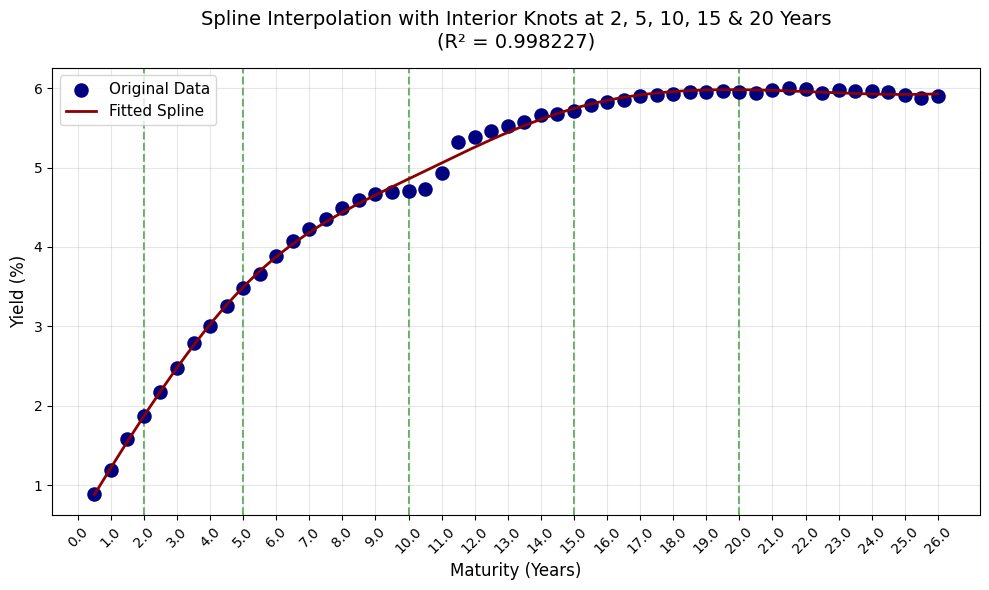

In [ ]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.scatter(X_data, Y_data, color='navy', s=80, zorder=2, label='Original Data', linewidth=1.5)

ax.plot(X_smooth_5_knots, Y_smooth_5_knots, color='darkred', linewidth=2, label='Fitted Spline', zorder=3)

for knot in custom_knots_5_knots.flatten():
    ax.axvline(x=knot, color='green', linestyle='--', alpha=0.6, linewidth=1.5, zorder=1)

ax.set_xlabel('Maturity (Years)', fontsize=12)
ax.set_ylabel('Yield (%)', fontsize=12)
ax.set_title(f'Spline Interpolation with Interior Knots at 2, 5, 10, 15 & 20 Years\n(R² = {r2_5_knots:.6f})', fontsize=14, pad=15)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

int_xticks = np.arange(np.floor(min(X_data)), np.ceil(max(X_data)) + 1, 1)
ax.set_xticks(int_xticks)
ax.set_xticklabels(int_xticks, rotation=45)

plt.tight_layout()
plt.show()

In [76]:
# Transform % to decimal
y_fit_5_knots = Y_smooth_5_knots / 100.0  

# We need 1D date
X_smooth_ravel_5_knots = X_smooth_5_knots.ravel()

# Calculating the estimated discount factor
df_spline_5_knots = 1.0 / ( 1.0 + y_fit_5_knots/coupon_frequency ) ** (X_smooth_ravel_5_knots * 2)

# --- Interpolate spline DF onto market maturities ---
mats_mkt = data['Maturity (years)'].to_numpy()
df_mkt   = data['Discount Factor'].to_numpy()

df_spline_at_mkt_5_knots = np.interp(mats_mkt, X_smooth_ravel_5_knots, df_spline_5_knots)
diff_df_5_knots = df_mkt - df_spline_at_mkt_5_knots

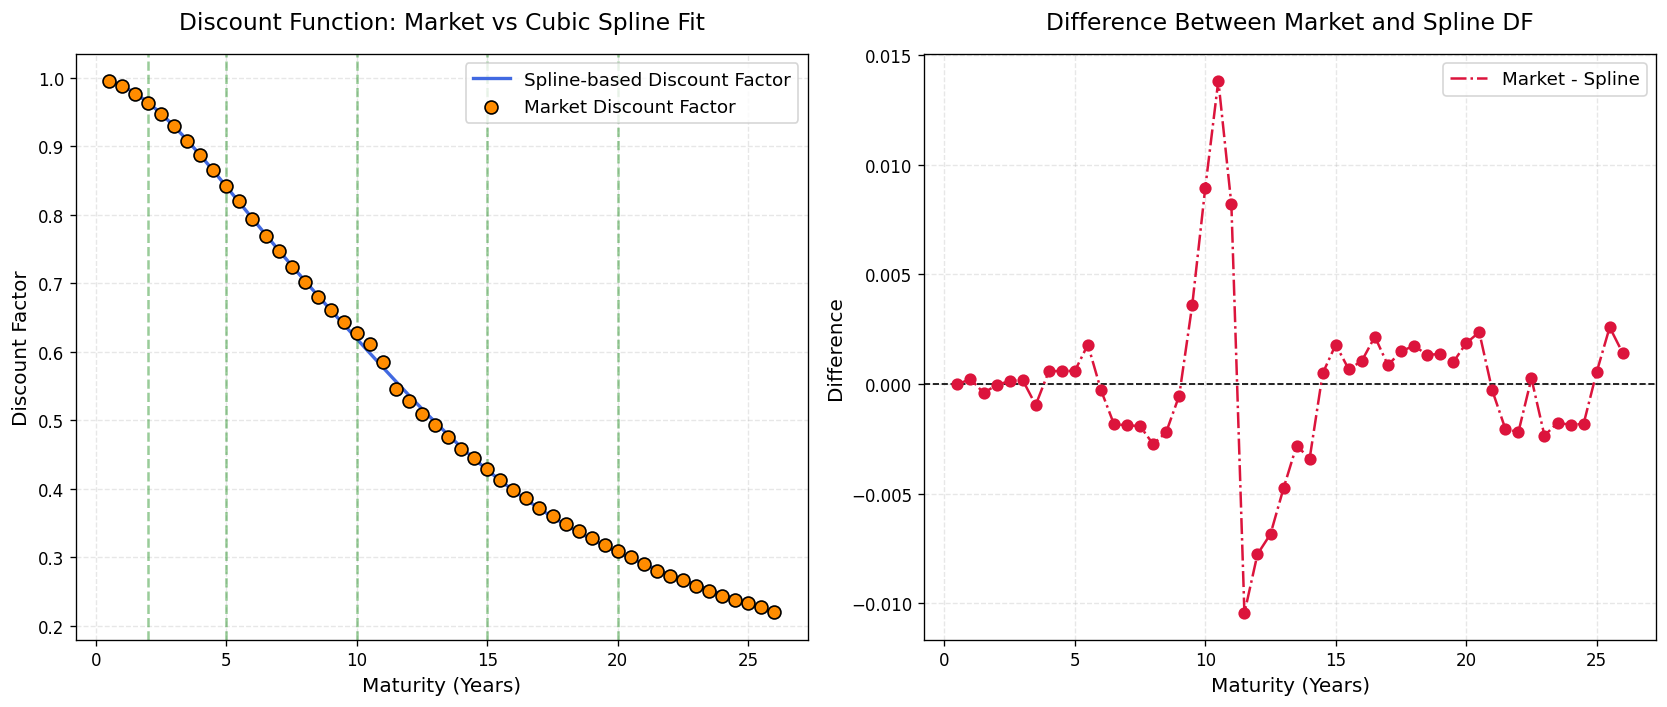

In [77]:
# --- Two subplots side-by-side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)

# (1) Discount factor comparison
ax1.plot(X_smooth_ravel_5_knots, df_spline_5_knots,
         color="royalblue", linewidth=2, linestyle="-",
         label="Spline-based Discount Factor"
         )

ax1.scatter(mats_mkt, df_mkt,
            color="darkorange", s=60, edgecolor="black",
            marker="o", label="Market Discount Factor", zorder=5
            )

for knot in custom_knots_5_knots.flatten():
    ax1.axvline(knot, color="green", linestyle="--", alpha=0.4)

ax1.set_xlabel("Maturity (Years)", fontsize=12)
ax1.set_ylabel("Discount Factor", fontsize=12)
ax1.set_title("Discount Function: Market vs Cubic Spline Fit", fontsize=14, pad=15)
ax1.grid(True, alpha=0.3, linestyle="--")
ax1.legend(loc="upper right", frameon=True, fontsize=11)

# (2) Difference subplot
ax2.axhline(0, color="black", linestyle="--", linewidth=1)
ax2.plot(mats_mkt, diff_df_5_knots, color="crimson", linewidth=1.5, linestyle="-.", label="Market - Spline")
ax2.scatter(mats_mkt, diff_df_5_knots, color="crimson", s=40, zorder=5)
ax2.set_xlabel("Maturity (Years)", fontsize=12)
ax2.set_ylabel("Difference", fontsize=12)
ax2.set_title("Difference Between Market and Spline DF", fontsize=14, pad=15)
ax2.grid(True, alpha=0.3, linestyle="--")
ax2.legend(loc="best", frameon=True, fontsize=11)

plt.tight_layout()
plt.show()

The LinearRegression used is the reason why knots points' values do not fit with the model. However, boundaries are not considered as knots which is a feature we were looking for.

- Knots: 2, 5, 10, 15, 20 years to capture short-, medium-, and long-term yields.


- LinearRegression fits spline coefficients minimizing squared error

### <font color='lightgreen' size=5> Q2.2: Discuss when using those new ‘spline-based’ zero-coupon yields estimates instead of the one implied by the bootstrapped zero-coupon bonds in Q1.1 is appropriate. Please justify and discuss whether this affects the conclusions reached in Q1.2?  </font>

### Using Spline-Based Zero-Coupon Yields

- **Intermediate maturities:** Spline interpolation is useful when we need estimates for **intermediate maturities** that are not directly observed in the market.  
  - This is particularly valuable for **pricing and hedging derivatives** with non-standard streams of cash flow.

- **Smooth curve:** Spline-based yields produce a **smooth term structure**, reducing noise from market fluctuations.  
  - This feature is especially relevant when **market volatility rises** and **market efficiency decreases**.

- **Impact on trading signals:**  
  - Using spline interpolation may **modify the amplitude of differences** between market yields (so the one computed by the spline model) and model-based yields (model by DB).  
  - However, the overall **trading signals (LONG or SHORT)** remain consistent.


In [78]:
ZC_Spline = pd.DataFrame(data={"Maturity (years)": X_smooth_ravel_5_knots,
                               "ZC_Yield_Spline": Y_smooth_5_knots})
ZC_Comparison_2 = pd.merge(merge_data_pd[['Maturity (years)', 'Model Prediction (BEY)']], ZC_Spline)
ZC_Comparison_2["Difference (bps)"] = (ZC_Comparison_2["ZC_Yield_Spline"] - ZC_Comparison_2['Model Prediction (BEY)']) * 100

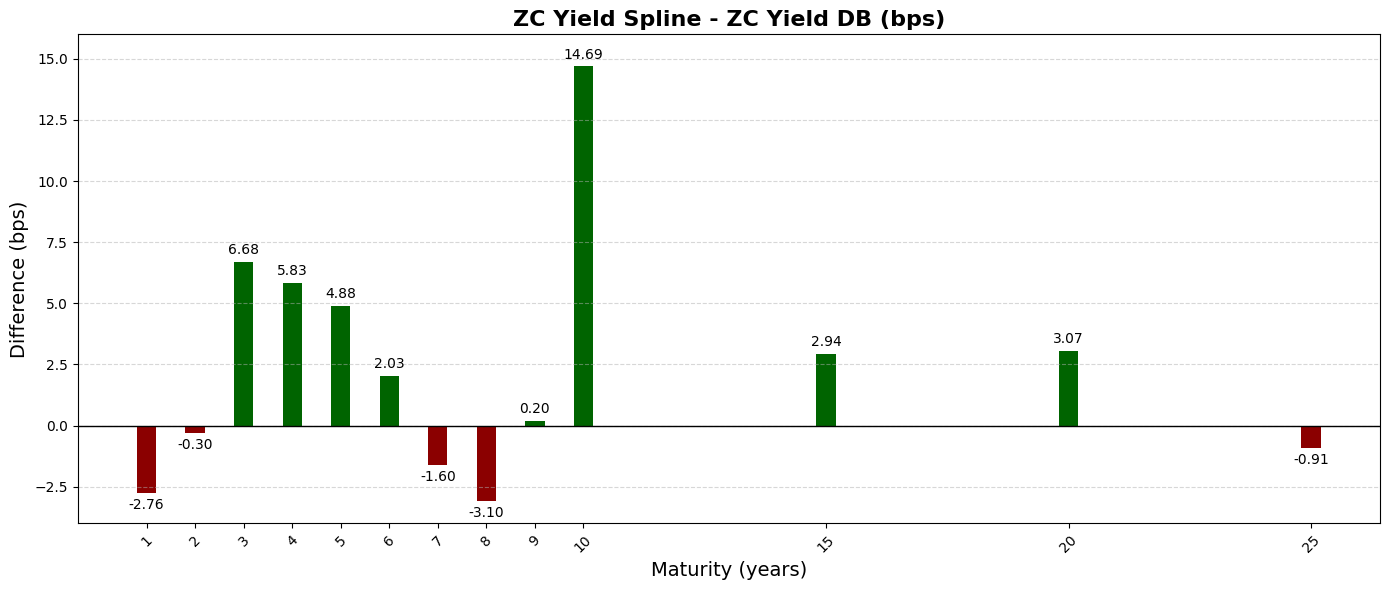

In [ ]:
plt.figure(figsize=(14,6))

colors = ["darkred" if x < 0 else "darkgreen" for x in ZC_Comparison_2["Difference (bps)"]]

bars = plt.bar(ZC_Comparison_2["Maturity (years)"], ZC_Comparison_2["Difference (bps)"], color=colors, width=0.4)

plt.title("ZC Yield Spline - ZC Yield DB (bps)", fontsize=16, fontweight="bold")
plt.xlabel("Maturity (years)", fontsize=14)
plt.ylabel("Difference (bps)", fontsize=14)

plt.grid(True, linestyle="--", alpha=0.5, axis="y")
plt.axhline(0, color="black", linewidth=1)

plt.ylim(-4, 16)

plt.xticks(ZC_Comparison_2["Maturity (years)"], rotation=45)

for bar, value in zip(bars, ZC_Comparison_2["Difference (bps)"]):
    height = bar.get_height()
    if height >= 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2,  # légèrement au-dessus
                 f"{value:.2f}", ha="center", va="bottom", fontsize=10)
    else:
        plt.text(bar.get_x() + bar.get_width()/2, height - 0.2,  # légèrement en dessous
                 f"{value:.2f}", ha="center", va="top", fontsize=10)

plt.tight_layout()
plt.show()


### <font color='lightgreen' size=5>Q2.3: Re-estimate the cubic splines’ function only using as knots 5- and 20-year zero-coupon yields. Plot the discount function against the one obtained in Q2.1. Discuss how changing the knots affects the estimated discount function.  </font>

In [80]:
X_data = data['Maturity (years)'].to_numpy()
Y_data = data['Zero Coupon Yields (%)'].to_numpy()
custom_knots_2_knots = np.array([5., 20.])

X_smooth_2_knots, Y_smooth_2_knots, r2_2_knots = cubic_spline(X_data, Y_data, custom_knots_2_knots)

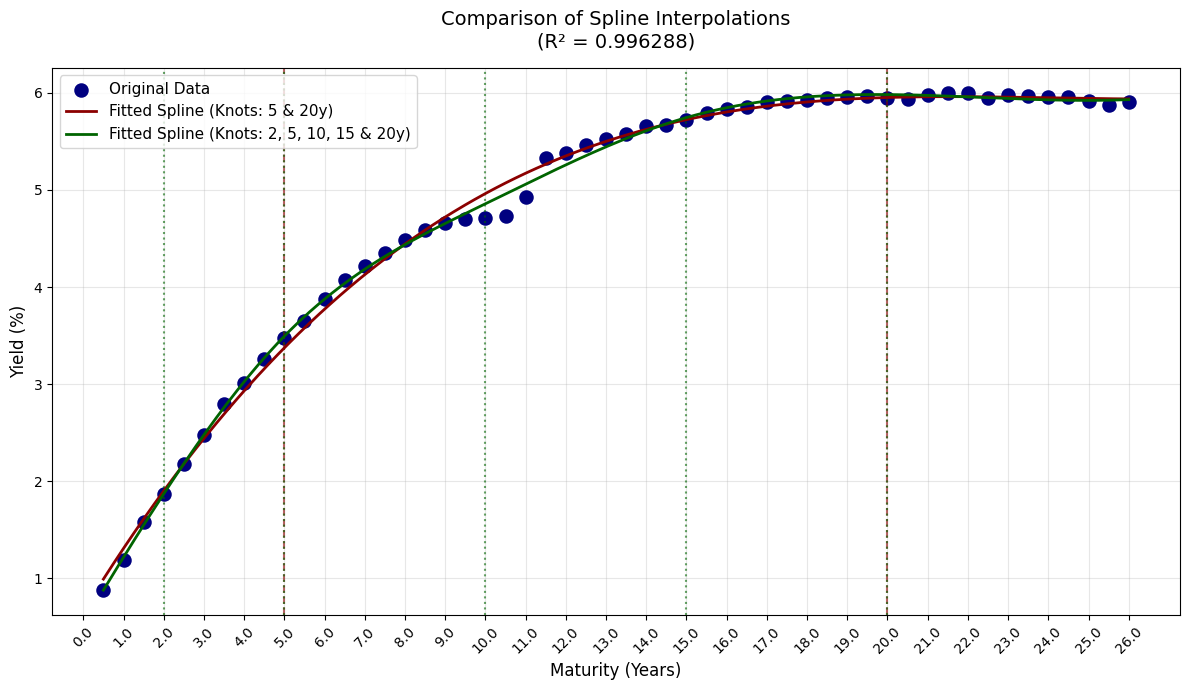

In [ ]:
plt.figure(figsize=(12, 7))
ax = plt.gca()

ax.scatter(X_data, Y_data, color='navy', s=80, zorder=2, 
           label='Original Data', linewidth=1.5)

ax.plot(X_smooth_2_knots, Y_smooth_2_knots, color='darkred', linewidth=2,
        label='Fitted Spline (Knots: 5 & 20y)', zorder=3)

for knot in custom_knots_2_knots.flatten():
    ax.axvline(x=knot, color='darkred', linestyle='--', alpha=0.6, linewidth=1.5)

ax.plot(X_smooth_5_knots, Y_smooth_5_knots, color='darkgreen', linewidth=2,
        label='Fitted Spline (Knots: 2, 5, 10, 15 & 20y)', zorder=3)

for knot in custom_knots_5_knots.flatten():
    ax.axvline(x=knot, color='darkgreen', linestyle=':', alpha=0.6, linewidth=1.5)

ax.set_xlabel('Maturity (Years)', fontsize=12)
ax.set_ylabel('Yield (%)', fontsize=12)
ax.set_title(f'Comparison of Spline Interpolations\n(R² = {r2_2_knots:.6f})',
             fontsize=14, pad=15)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

int_xticks = np.arange(np.floor(min(X_data)), np.ceil(max(X_data)) + 1, 1)
ax.set_xticks(int_xticks)
ax.set_xticklabels(int_xticks, rotation=45)

plt.tight_layout()
plt.show()

In [82]:
# Transform % to decimal
y_fit_2_knots = Y_smooth_2_knots / 100.0  

# We need 1D date
X_smooth_ravel = X_smooth_2_knots.ravel()

# Calculating the estimated discount factor
df_spline_2_knots = 1.0 / (1.0 + y_fit_2_knots/coupon_frequency ) ** (X_smooth_ravel * 2)

df_spline_at_mkt_2_knots = np.interp(mats_mkt, X_smooth_ravel, df_spline_2_knots)
diff_df_2_knots = df_mkt - df_spline_at_mkt_2_knots

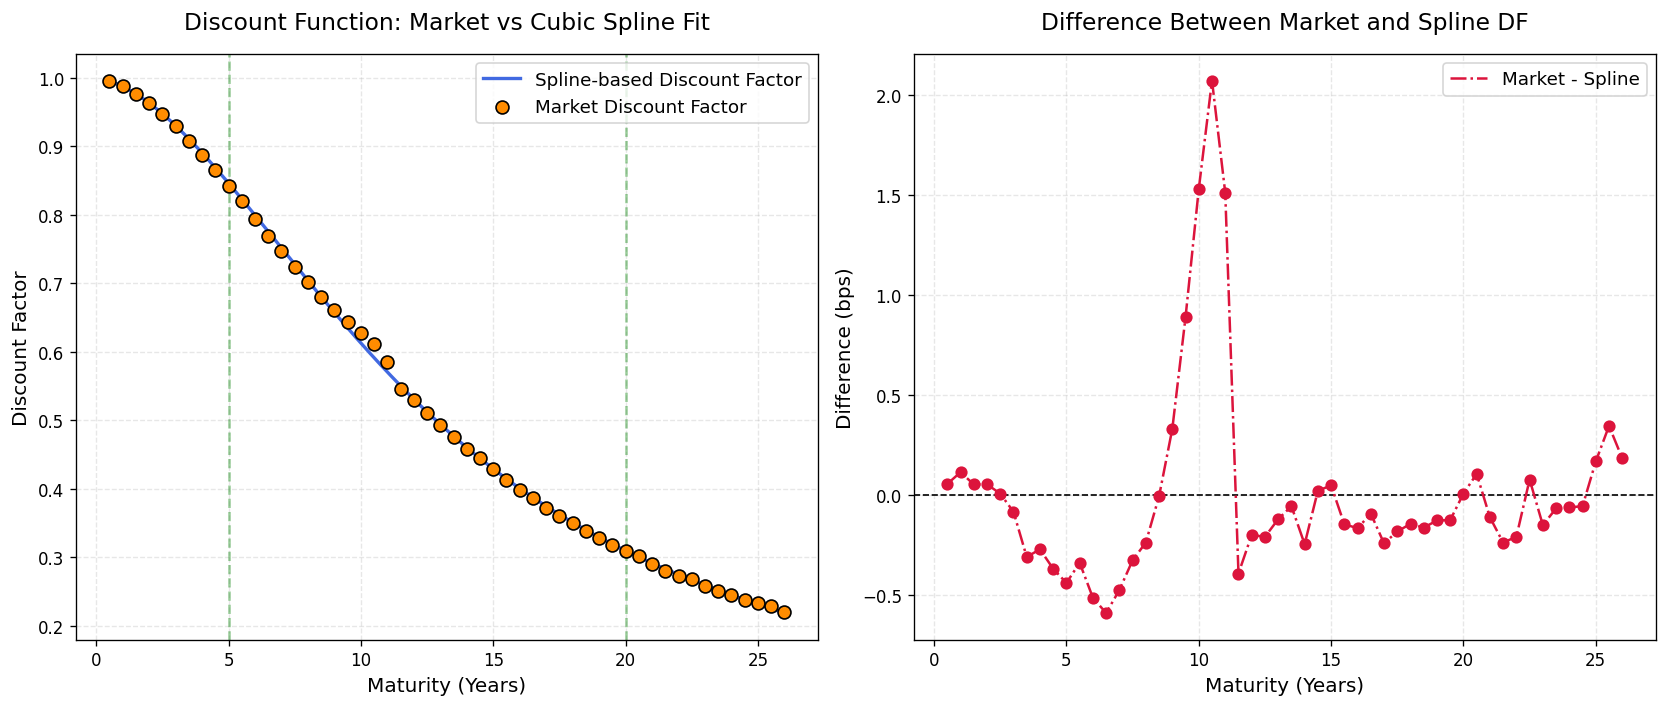

In [83]:
# --- Two subplots side-by-side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)

# (1) Discount factor comparison
ax1.plot(
    X_smooth_ravel, df_spline_2_knots,
    color="royalblue", linewidth=2, linestyle="-",
    label="Spline-based Discount Factor"
    )

ax1.scatter(
    mats_mkt, df_mkt,
    color="darkorange", s=60, edgecolor="black",
    marker="o", label="Market Discount Factor", zorder=5
    )

for knot in custom_knots_2_knots.flatten():
    ax1.axvline(knot, color="green", linestyle="--", alpha=0.4)

ax1.set_xlabel("Maturity (Years)", fontsize=12)
ax1.set_ylabel("Discount Factor", fontsize=12)
ax1.set_title("Discount Function: Market vs Cubic Spline Fit", fontsize=14, pad=15)
ax1.grid(True, alpha=0.3, linestyle="--")
ax1.legend(loc="upper right", frameon=True, fontsize=11)

# (2) Difference subplot
ax2.axhline(0, color="black", linestyle="--", linewidth=1)
ax2.plot(mats_mkt, diff_df_2_knots * 100, color="crimson", linewidth=1.5, linestyle="-.", label="Market - Spline")
ax2.scatter(mats_mkt, diff_df_2_knots * 100, color="crimson", s=40, zorder=5)
ax2.set_xlabel("Maturity (Years)", fontsize=12)
ax2.set_ylabel("Difference (bps)", fontsize=12)
ax2.set_title("Difference Between Market and Spline DF", fontsize=14, pad=15)
ax2.grid(True, alpha=0.3, linestyle="--")
ax2.legend(loc="best", frameon=True, fontsize=11)

plt.tight_layout()
plt.show()

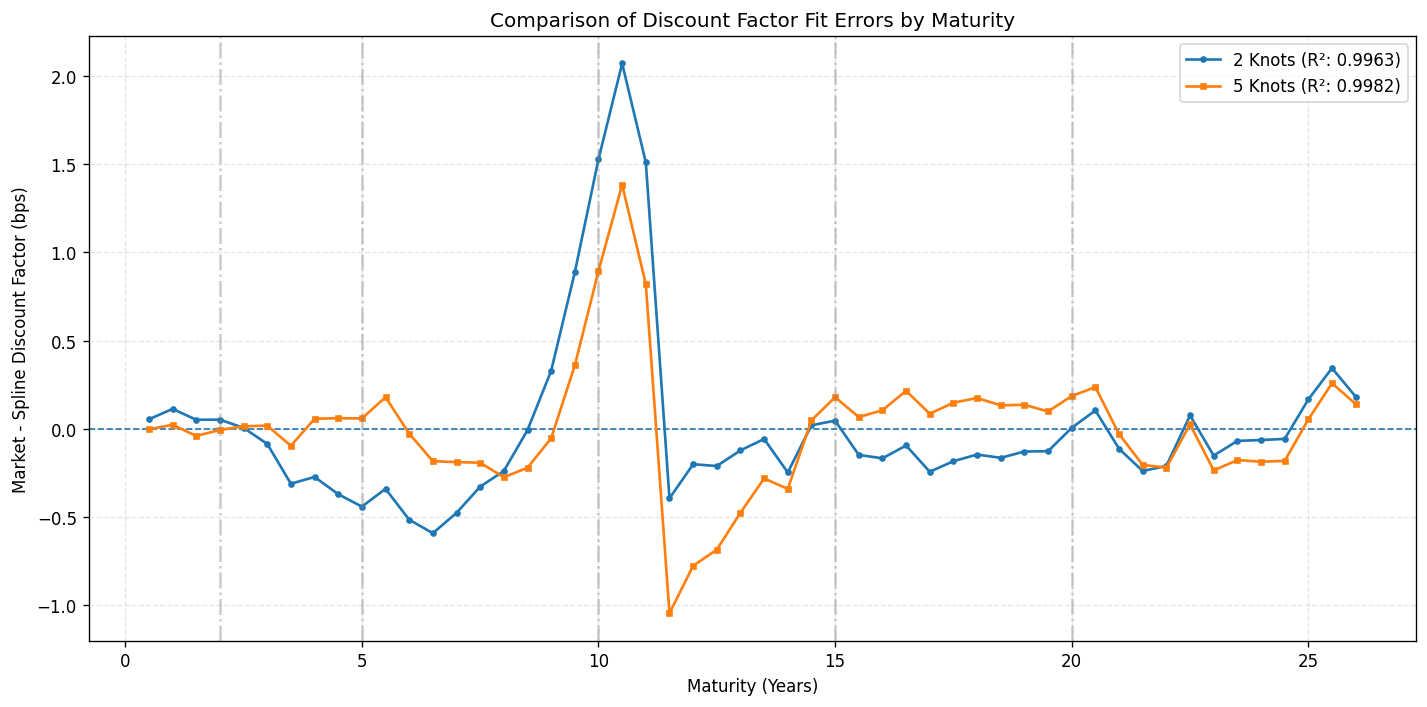

In [84]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Zero line + tolerance band
ax.axhline(0, linestyle='--', linewidth=1)

# Error curves
ax.plot(mats_mkt, diff_df_2_knots * 100, marker='o', markersize=3, linewidth=1.6,
        label=f'2 Knots (R²: {r2_2_knots:.4f})')
ax.plot(mats_mkt, diff_df_5_knots * 100, marker='s', markersize=3, linewidth=1.6,
        label=f'5 Knots (R²: {r2_5_knots:.4f})')

# Knot guides (dash-dot for 2-knot model; dotted for the extra 5-knot locations)
for k in custom_knots_5_knots:
    ax.axvline(k, linestyle='-.', alpha=0.4, color='grey')

# Labels, title, grid, legend
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Market - Spline Discount Factor (bps)')
ax.set_title('Comparison of Discount Factor Fit Errors by Maturity')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', frameon=True)

plt.tight_layout()
plt.show()


<font color='red' size=8>QUESTION 3 - NELSON-SIEGEL-MODEL</font>


<font color='lightgreen' size=5> Q3.1: Estimate the discount function according to the Nelson-Siegel-Svensson model. Describe 
succinctly  the  methodology  and  document  any  choice  made  in  the  estimation.  Plot  it 
against the zero-coupon yields obtained in Q1.1.   </font>

In [85]:
ns_spot_params = calibrate_yield_curve(
    data['Maturity (years)'].to_numpy(),
    data['Zero Coupon Yields (%)'].to_numpy() / 100)

# Generate curves for plotting
tau_plot = np.linspace(X_data.min(), X_data.max(), 500)

# Fitted spot curve (Nelson-Siegel-Svensson)
fitted_spot_ns = yield_curve_model(
    tau_plot, 
    ns_spot_params['beta0'], 
    ns_spot_params['beta1'], 
    ns_spot_params['beta2'],
    ns_spot_params['beta3'],
    ns_spot_params['lambda1'],
    ns_spot_params['lambda2']
    )

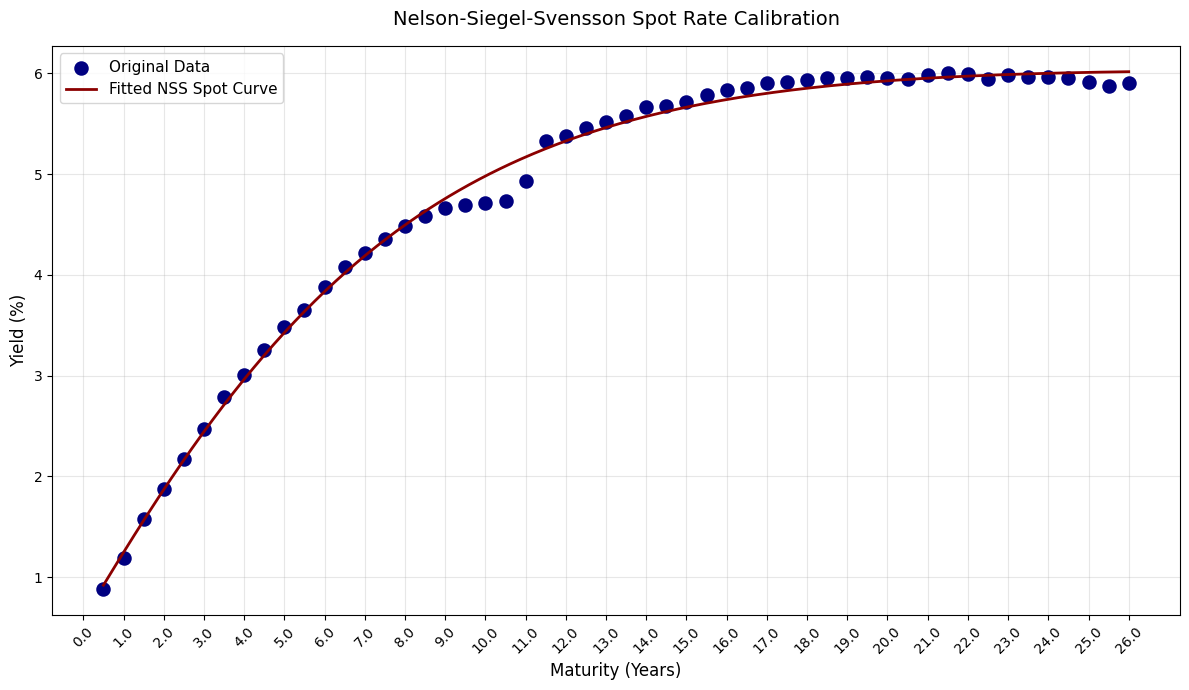

In [ ]:
plt.figure(figsize=(12, 7))
ax = plt.gca()

ax.scatter(
    data['Maturity (years)'], 
    data['Zero Coupon Yields (%)'], 
    color="navy", s=80, zorder=2,
    label="Original Data", linewidth=1.5
)

ax.plot(
    tau_plot, fitted_spot_ns * 100,
    color="darkred", linewidth=2, zorder=3,
    label="Fitted NSS Spot Curve"
)

ax.set_xlabel("Maturity (Years)", fontsize=12)
ax.set_ylabel("Yield (%)", fontsize=12)
ax.set_title("Nelson-Siegel-Svensson Spot Rate Calibration", fontsize=14, pad=15)
ax.legend(loc="upper left", fontsize=11)
ax.grid(True, alpha=0.3)

int_xticks = np.arange(
    np.floor(data['Maturity (years)'].min()), 
    np.ceil(data['Maturity (years)'].max()) + 1, 1
)
ax.set_xticks(int_xticks)
ax.set_xticklabels(int_xticks, rotation=45)

plt.tight_layout()
plt.show()

In [87]:
# Calculating the estimated discount factor
df_NSS = 1.0 / ( 1.0 + fitted_spot_ns/coupon_frequency ) ** (tau_plot * 2)

df_NSS_at_mkt = np.interp(mats_mkt, tau_plot, df_NSS)
diff_df_NSS = df_mkt - df_NSS_at_mkt

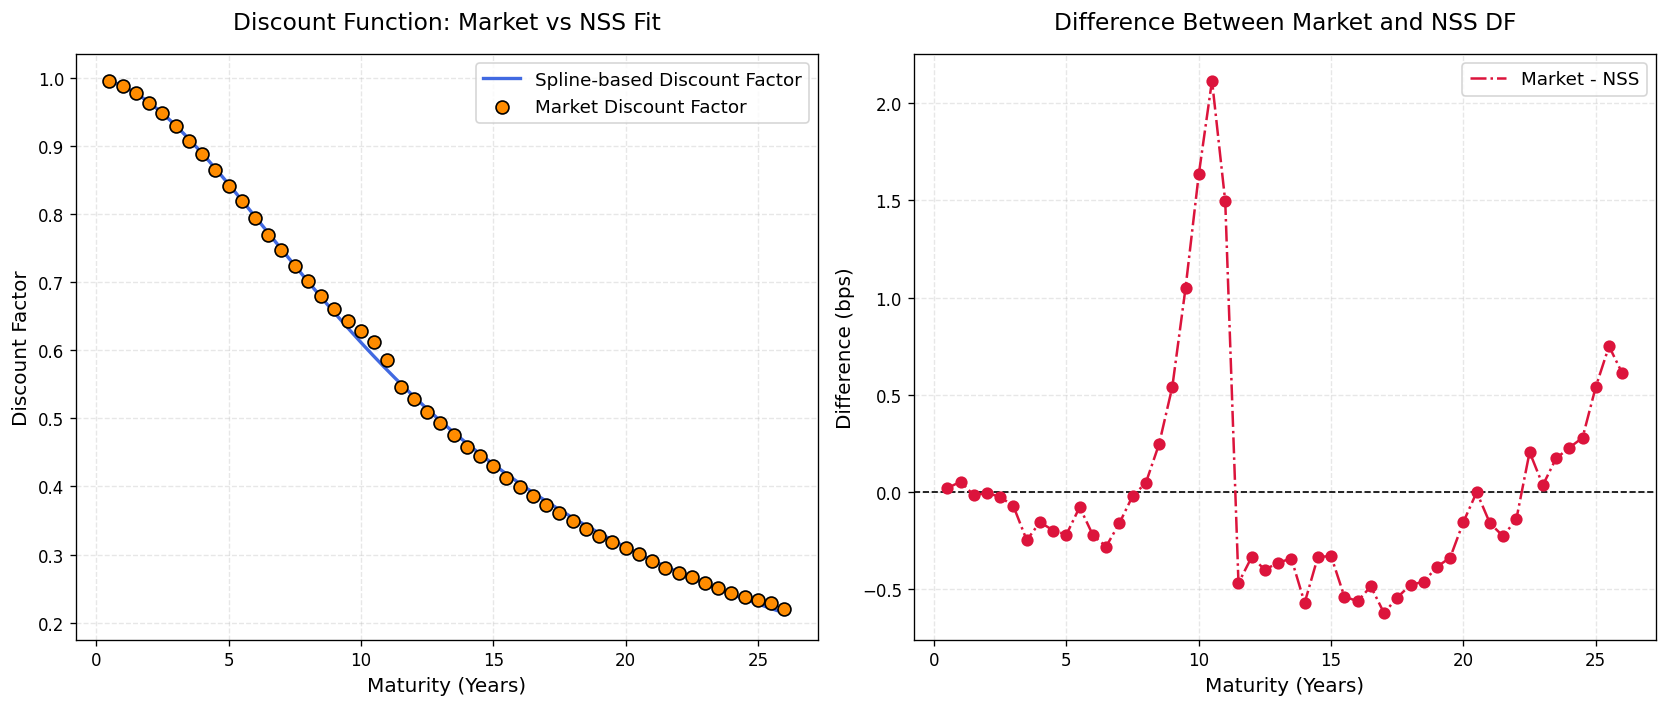

In [88]:
# --- Two subplots side-by-side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=120)

# (1) Discount factor comparison
ax1.plot(
    tau_plot, df_NSS,
    color="royalblue", linewidth=2, linestyle="-",
    label="Spline-based Discount Factor"
    )

ax1.scatter(
    mats_mkt, df_mkt,
    color="darkorange", s=60, edgecolor="black",
    marker="o", label="Market Discount Factor", zorder=5
    )

ax1.set_xlabel("Maturity (Years)", fontsize=12)
ax1.set_ylabel("Discount Factor", fontsize=12)
ax1.set_title("Discount Function: Market vs NSS Fit", fontsize=14, pad=15)
ax1.grid(True, alpha=0.3, linestyle="--")
ax1.legend(loc="upper right", frameon=True, fontsize=11)

# (2) Difference subplot
ax2.axhline(0, color="black", linestyle="--", linewidth=1)
ax2.plot(mats_mkt, diff_df_NSS * 100, color="crimson", linewidth=1.5, linestyle="-.", label="Market - NSS")
ax2.scatter(mats_mkt, diff_df_NSS * 100, color="crimson", s=40, zorder=5)
ax2.set_xlabel("Maturity (Years)", fontsize=12)
ax2.set_ylabel("Difference (bps)", fontsize=12)
ax2.set_title("Difference Between Market and NSS DF", fontsize=14, pad=15)
ax2.grid(True, alpha=0.3, linestyle="--")
ax2.legend(loc="best", frameon=True, fontsize=11)

plt.tight_layout()
plt.show()

### <font color='lightgreen' size=5>Q3.2: Compare the fit of the two models from Q2.1 and Q3.1. Discuss the differences.   </font>

In [89]:
ZC_NSS = pd.DataFrame(data={"Maturity (years)": tau_plot,
                            "ZC_yield_NSS": fitted_spot_ns * 100})

ZC_Comparison_2 = pd.merge_asof(ZC_Comparison_2, ZC_NSS, direction = 'nearest', on='Maturity (years)')
ZC_Comparison_2['Difference_2 (bps)'] = (ZC_Comparison_2['ZC_yield_NSS'] - ZC_Comparison_2["Model Prediction (BEY)"]) * 100

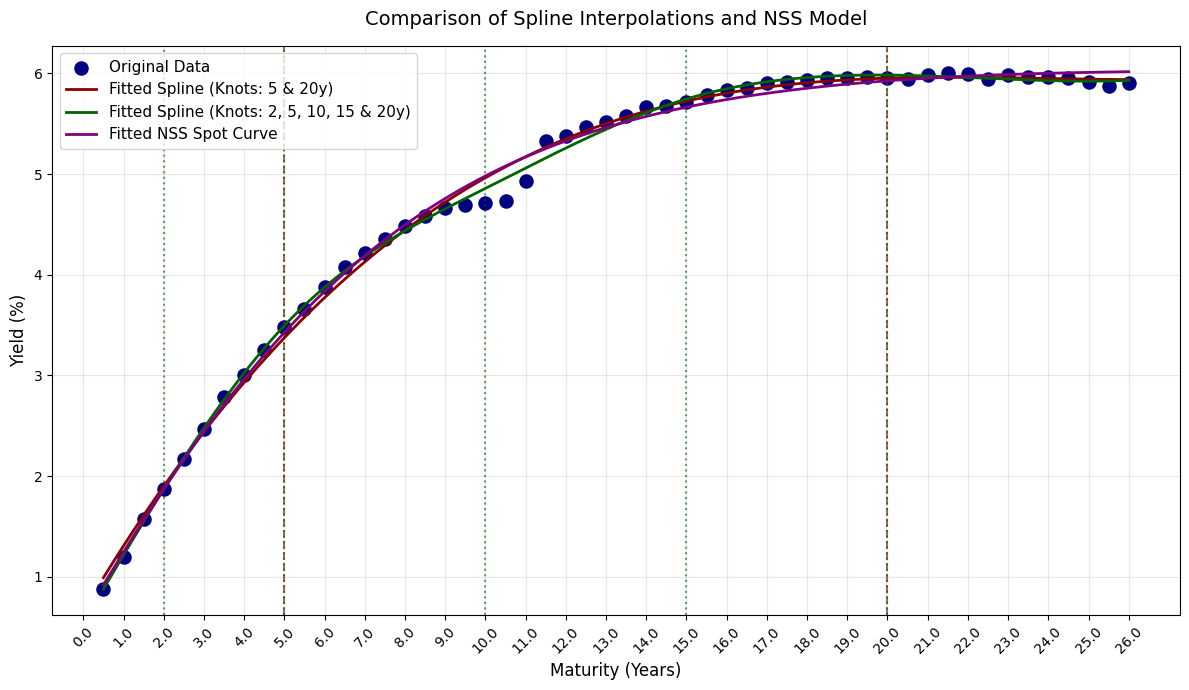

{'model': 'Svensson',
 'beta0': np.float64(0.05861069514844971),
 'beta1': np.float64(-0.052721662695671974),
 'beta2': np.float64(-0.11969510893224343),
 'beta3': np.float64(0.15),
 'lambda1': np.float64(3.9750183713345493),
 'lambda2': np.float64(4.966226024886784),
 'success': True,
 'sse': np.float64(4.5816383326979686e-05),
 'rmse': np.float64(0.0009386609050927866),
 'n_params': 6,
 'convergence_message': 'CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH'}

In [ ]:
plt.figure(figsize=(12, 7))
ax = plt.gca()

ax.scatter(X_data, Y_data, color='navy', s=80, zorder=2, 
           label='Original Data', linewidth=1.5)

ax.plot(X_smooth_2_knots, Y_smooth_2_knots, color='darkred', linewidth=2,
        label='Fitted Spline (Knots: 5 & 20y)', zorder=3)
for knot in custom_knots_2_knots.flatten():
    ax.axvline(x=knot, color='darkred', linestyle='--', alpha=0.6, linewidth=1.5)

ax.plot(X_smooth_5_knots, Y_smooth_5_knots, color='darkgreen', linewidth=2,
        label='Fitted Spline (Knots: 2, 5, 10, 15 & 20y)', zorder=3)
for knot in custom_knots_5_knots.flatten():
    ax.axvline(x=knot, color='darkgreen', linestyle=':', alpha=0.6, linewidth=1.5)

ax.plot(tau_plot, fitted_spot_ns*100, color='purple', linewidth=2,
        label='Fitted NSS Spot Curve', zorder=4)

ax.set_xlabel('Maturity (Years)', fontsize=12)
ax.set_ylabel('Yield (%)', fontsize=12)
ax.set_title('Comparison of Spline Interpolations and NSS Model', fontsize=14, pad=15)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

int_xticks = np.arange(np.floor(min(X_data)), np.ceil(max(X_data)) + 1, 1)
ax.set_xticks(int_xticks)
ax.set_xticklabels(int_xticks, rotation=45)

plt.tight_layout()
plt.show()
ns_spot_params

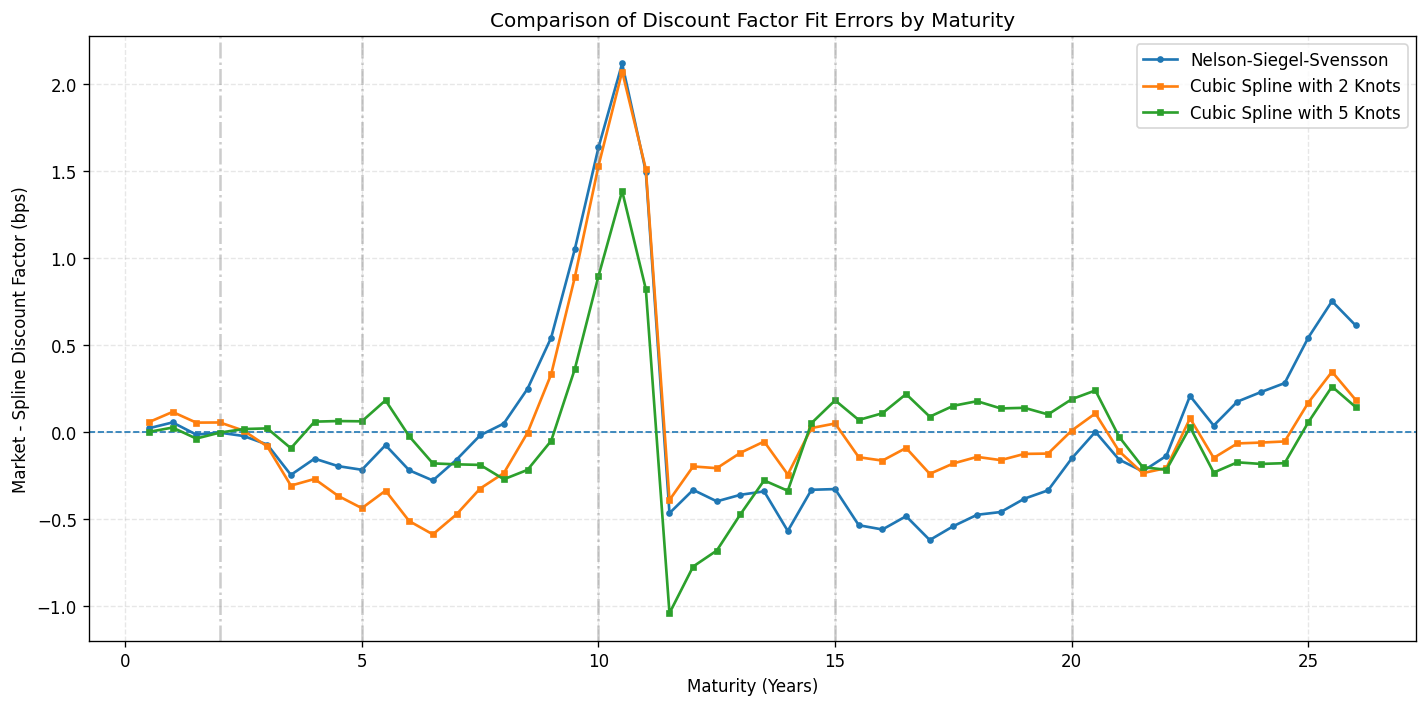

In [91]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Zero line + tolerance band
ax.axhline(0, linestyle='--', linewidth=1)

# Error curves
ax.plot(mats_mkt, diff_df_NSS * 100, marker='o', markersize=3, linewidth=1.6,
        label=f'Nelson-Siegel-Svensson')
ax.plot(mats_mkt, diff_df_2_knots * 100, marker='s', markersize=3, linewidth=1.6,
        label=f'Cubic Spline with 2 Knots')
ax.plot(mats_mkt, diff_df_5_knots * 100, marker='s', markersize=3, linewidth=1.6,
        label=f'Cubic Spline with 5 Knots')

# Knot guides (dash-dot for 2-knot model; dotted for the extra 5-knot locations)
for k in custom_knots_5_knots:
    ax.axvline(k, linestyle='-.', alpha=0.4, color='grey')

# Labels, title, grid, legend
ax.set_xlabel('Maturity (Years)')
ax.set_ylabel('Market - Spline Discount Factor (bps)')
ax.set_title('Comparison of Discount Factor Fit Errors by Maturity')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', frameon=True)

plt.tight_layout()
plt.show()


<font color='lightgreen' size=5>Q3.3: Estimate and plot the factor loadings and contributions from the different factors affecting 
the shape of the spot zero-coupon curve. Explain their key drivers.   </font>

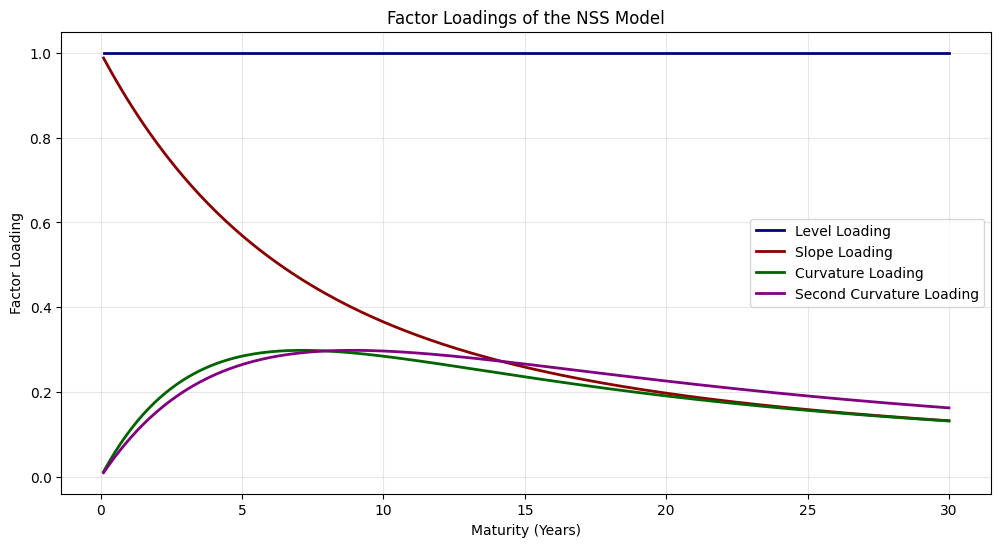

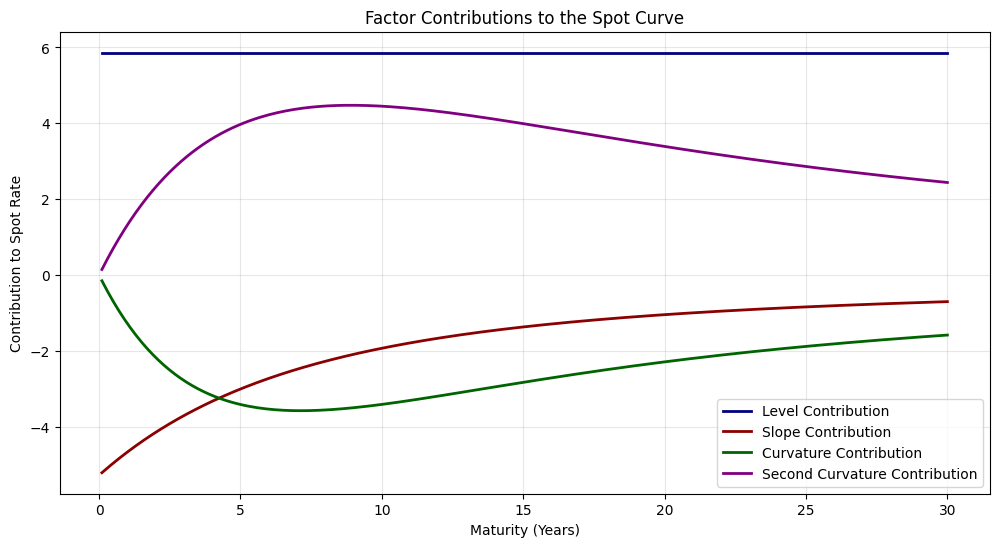

In [92]:
fitted_spot_ns = yield_curve_model(
    tau_plot, 
    ns_spot_params['beta0'], 
    ns_spot_params['beta1'], 
    ns_spot_params['beta2'],
    ns_spot_params['beta3'],
    ns_spot_params['lambda1'],
    ns_spot_params['lambda2']
    )

# Example maturities
tau = np.linspace(0.1, 30, 300)

# Example fitted parameters from NSS
beta0, beta1, beta2, beta3 = ns_spot_params['beta0'], ns_spot_params['beta1'], ns_spot_params['beta2'], ns_spot_params['beta3']
lambda1, lambda2 = ns_spot_params['lambda1'], ns_spot_params['lambda2']

# Factor loadings
f0 = np.ones_like(tau)
f1 = (1 - np.exp(-tau/lambda1)) / (tau / lambda1)
f2 = f1 - np.exp(- tau / lambda1)
f3 = (1 - np.exp(-tau / lambda2)) / (tau / lambda2) - np.exp(-tau / lambda2)

# Contributions
c0 = beta0 * f0
c1 = beta1 * f1
c2 = beta2 * f2
c3 = beta3 * f3

# Plot factor loadings
plt.figure(figsize=(12, 6))
plt.plot(tau, f0, label='Level Loading', color='navy', linewidth=2)
plt.plot(tau, f1, label='Slope Loading', color='darkred', linewidth=2)
plt.plot(tau, f2, label='Curvature Loading', color='darkgreen', linewidth=2)
plt.plot(tau, f3, label='Second Curvature Loading', color='purple', linewidth=2)
plt.title("Factor Loadings of the NSS Model")
plt.xlabel("Maturity (Years)")
plt.ylabel("Factor Loading")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot contributions
plt.figure(figsize=(12, 6))
plt.plot(tau, c0*100, label='Level Contribution', color='navy', linewidth=2)
plt.plot(tau, c1*100, label='Slope Contribution', color='darkred', linewidth=2)
plt.plot(tau, c2*100, label='Curvature Contribution', color='darkgreen', linewidth=2)
plt.plot(tau, c3*100, label='Second Curvature Contribution', color='purple', linewidth=2)
plt.title("Factor Contributions to the Spot Curve")
plt.xlabel("Maturity (Years)")
plt.ylabel("Contribution to Spot Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


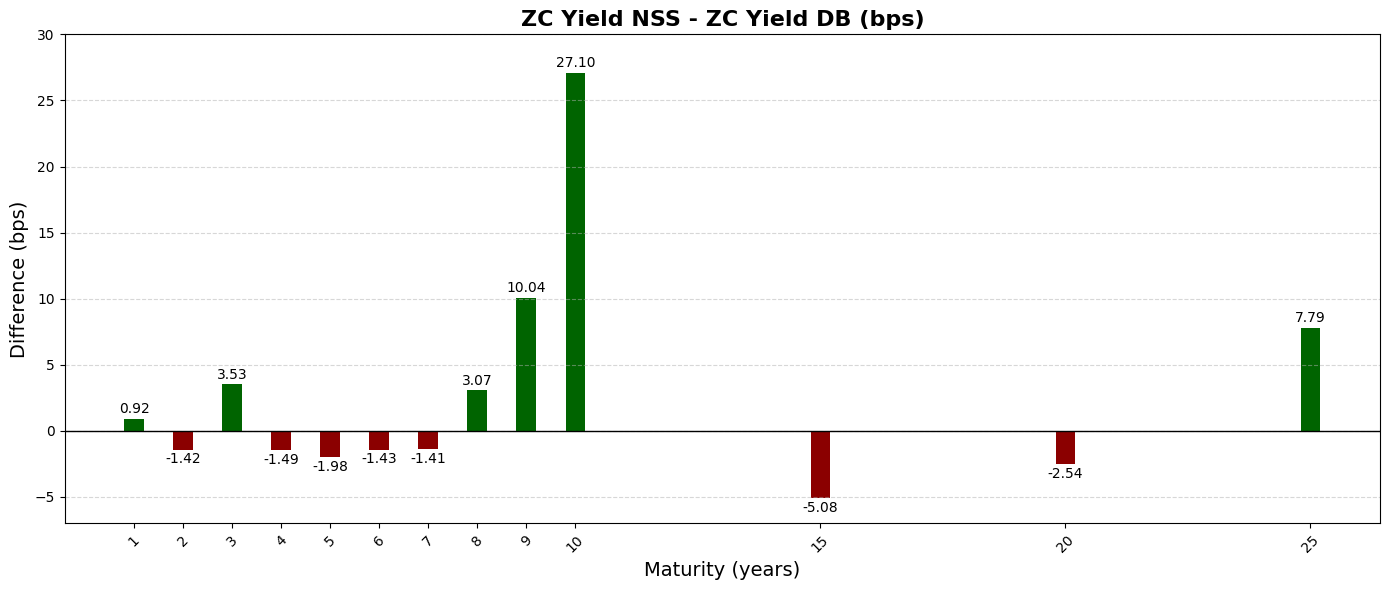

In [ ]:
plt.figure(figsize=(14,6))

colors = ["darkred" if x < 0 else "darkgreen" for x in ZC_Comparison_2["Difference_2 (bps)"]]

bars = plt.bar(ZC_Comparison_2["Maturity (years)"], ZC_Comparison_2["Difference_2 (bps)"], color=colors, width=0.4)

plt.title("ZC Yield NSS - ZC Yield DB (bps)", fontsize=16, fontweight="bold")
plt.xlabel("Maturity (years)", fontsize=14)
plt.ylabel("Difference (bps)", fontsize=14)

plt.grid(True, linestyle="--", alpha=0.5, axis="y")
plt.axhline(0, color="black", linewidth=1)

plt.ylim(-7, 30)

plt.xticks(ZC_Comparison_2["Maturity (years)"], rotation=45)

for bar, value in zip(bars, ZC_Comparison_2["Difference_2 (bps)"]):
    height = bar.get_height()
    if height >= 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, 
                 f"{value:.2f}", ha="center", va="bottom", fontsize=10)
    else:
        plt.text(bar.get_x() + bar.get_width()/2, height - 0.2,
                 f"{value:.2f}", ha="center", va="top", fontsize=10)

plt.tight_layout()
plt.show()


<font color='red' size=8>QUESTION 4 - HEDGING</font>


<font color='lightgreen' size=5> Q4.1: To estimate the sensitivity of any instrument or portfolio to the 10-year rate changes, i.e., 
its  10-year  key  rate  duration  (KRD),  you  will  shock  the  10-year  rate  by  50bps.  Discuss 
what the impact is on the zero coupon yield curve estimated in Q2.1? Plot the difference.   </font>

In [94]:
bump_bp = 50
bump = bump_bp / 1e2 # Instead of 1e4 because i'm using % values

data_shock = pd.DataFrame(columns=data.columns, data=data)
old_rate = data_shock.loc[data_shock['Maturity (years)'] == 10, 'Zero Coupon Yields (%)'].values
new_rate = old_rate + bump

data_shock.loc[data_shock['Maturity (years)'] == 10, 'Zero Coupon Yields (%)'] = new_rate

In [95]:
X_data = data_shock['Maturity (years)'].to_numpy()
Y_data = data_shock['Zero Coupon Yields (%)'].to_numpy()

X_smooth_shock, Y_smooth_shock, r2_shock = cubic_spline(X_data, Y_data, custom_knots_5_knots)

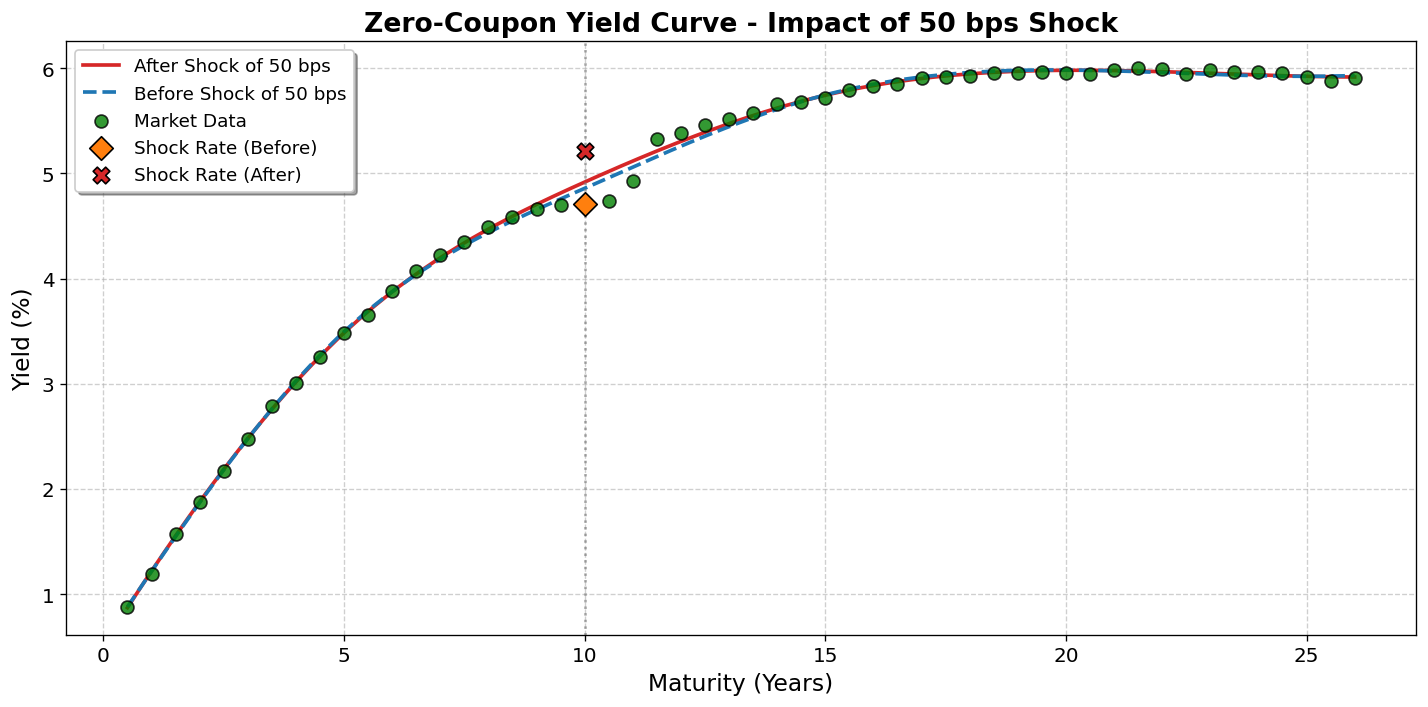

In [ ]:
plt.figure(figsize=(12, 6), dpi=120)

plt.plot(X_smooth_5_knots, Y_smooth_shock, 
         label='After Shock of 50 bps', 
         color='tab:red', linewidth=2.2)

plt.plot(X_smooth_5_knots, Y_smooth_5_knots, 
         label='Before Shock of 50 bps', 
         color='tab:blue', linewidth=2.2, linestyle="--")

plt.scatter(data['Maturity (years)'], data['Zero Coupon Yields (%)'], 
            color='green', s=60, edgecolors="black", 
            zorder=5, label='Market Data', alpha=0.8)

plt.scatter(10, old_rate, 
            color='tab:orange', s=100, edgecolors="black", 
            marker='D', zorder=6, label='Shock Rate (Before)')

plt.scatter(10, new_rate, 
            color='tab:red', s=100, edgecolors="black", 
            marker='X', zorder=7, label='Shock Rate (After)')

plt.title("Zero-Coupon Yield Curve - Impact of 50 bps Shock", fontsize=16, weight='bold')
plt.xlabel("Maturity (Years)", fontsize=14)
plt.ylabel("Yield (%)", fontsize=14)

plt.grid(True, linestyle="--", alpha=0.6)

plt.legend(fontsize=11, loc="best", frameon=True, shadow=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.axvline(x=10, color="gray", linestyle=":", alpha=0.7)

plt.tight_layout()
plt.show()


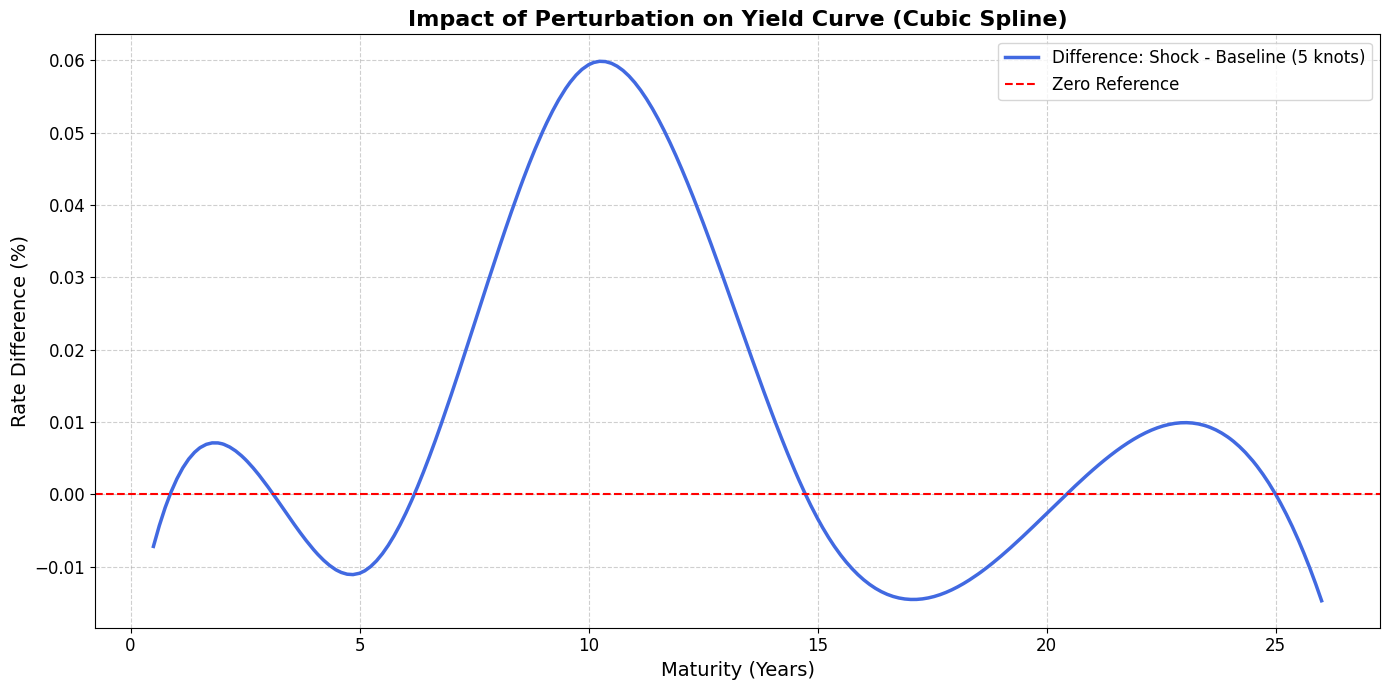

In [97]:
# Compute the difference
diff_spline_shock = Y_smooth_shock - Y_smooth_5_knots

# Create figure
plt.figure(figsize=(14, 7))

# Plot the difference line
plt.plot(
    X_smooth_shock, diff_spline_shock,
    color='royalblue',
    linewidth=2.5,
    label='Difference: Shock - Baseline (5 knots)'
)

# Add horizontal zero line
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Reference')

# Set titles and labels
plt.title('Impact of Perturbation on Yield Curve (Cubic Spline)', fontsize=16, fontweight='bold')
plt.xlabel('Maturity (Years)', fontsize=14)
plt.ylabel('Rate Difference (%)', fontsize=14)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend
plt.legend(fontsize=12, loc='best')

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()


In [98]:
Y_fit_shock = Y_smooth_shock / 100
X_smooth_shock_ravel = X_smooth_shock.ravel()

# Calculating the estimated discount factor
df_spline_shock = 1.0 / ( 1.0 + Y_fit_shock/coupon_frequency ) ** (X_smooth_shock_ravel * 2)

diff_df_spline_shock = df_spline_shock - df_spline_5_knots

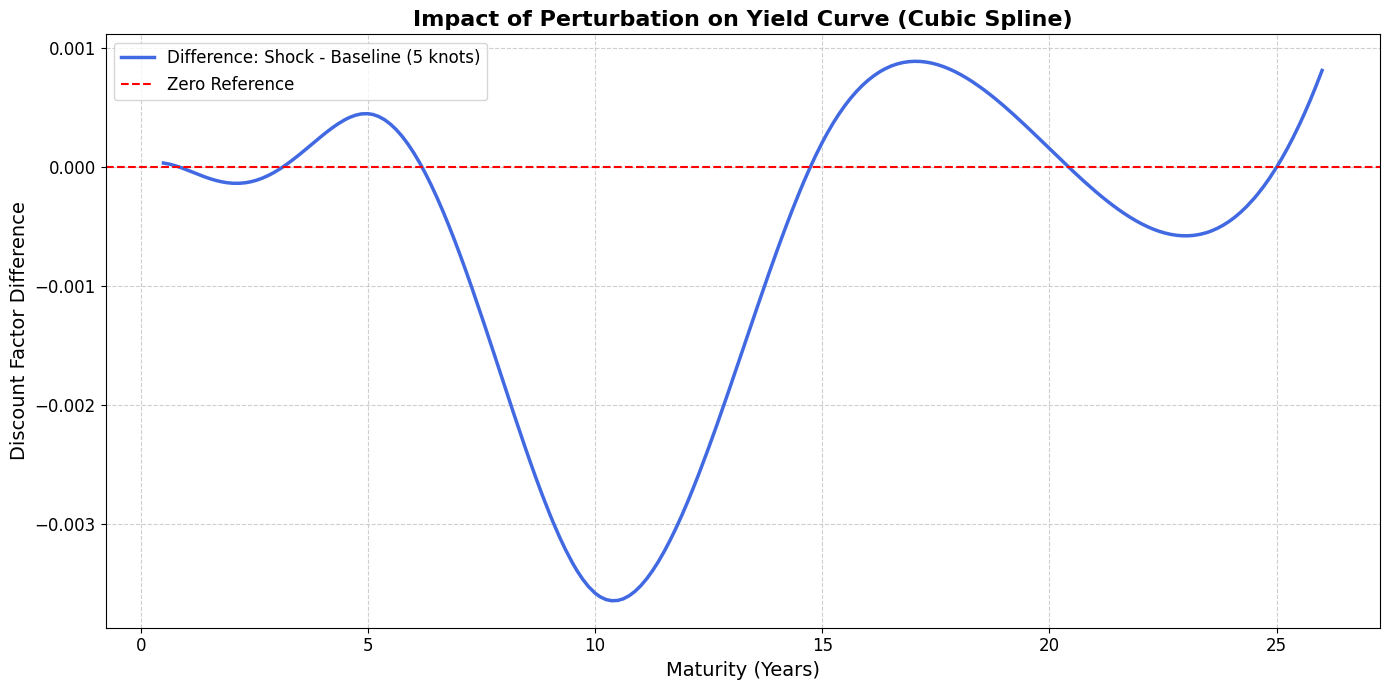

In [99]:
# Create figure
plt.figure(figsize=(14, 7))

# Plot the difference line
plt.plot(
    X_smooth_shock, diff_df_spline_shock,
    color='royalblue',
    linewidth=2.5,
    label='Difference: Shock - Baseline (5 knots)'
)

# Add horizontal zero line
plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Reference')

# Set titles and labels
plt.title('Impact of Perturbation on Yield Curve (Cubic Spline)', fontsize=16, fontweight='bold')
plt.xlabel('Maturity (Years)', fontsize=14)
plt.ylabel('Discount Factor Difference', fontsize=14)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend
plt.legend(fontsize=12, loc='best')

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()


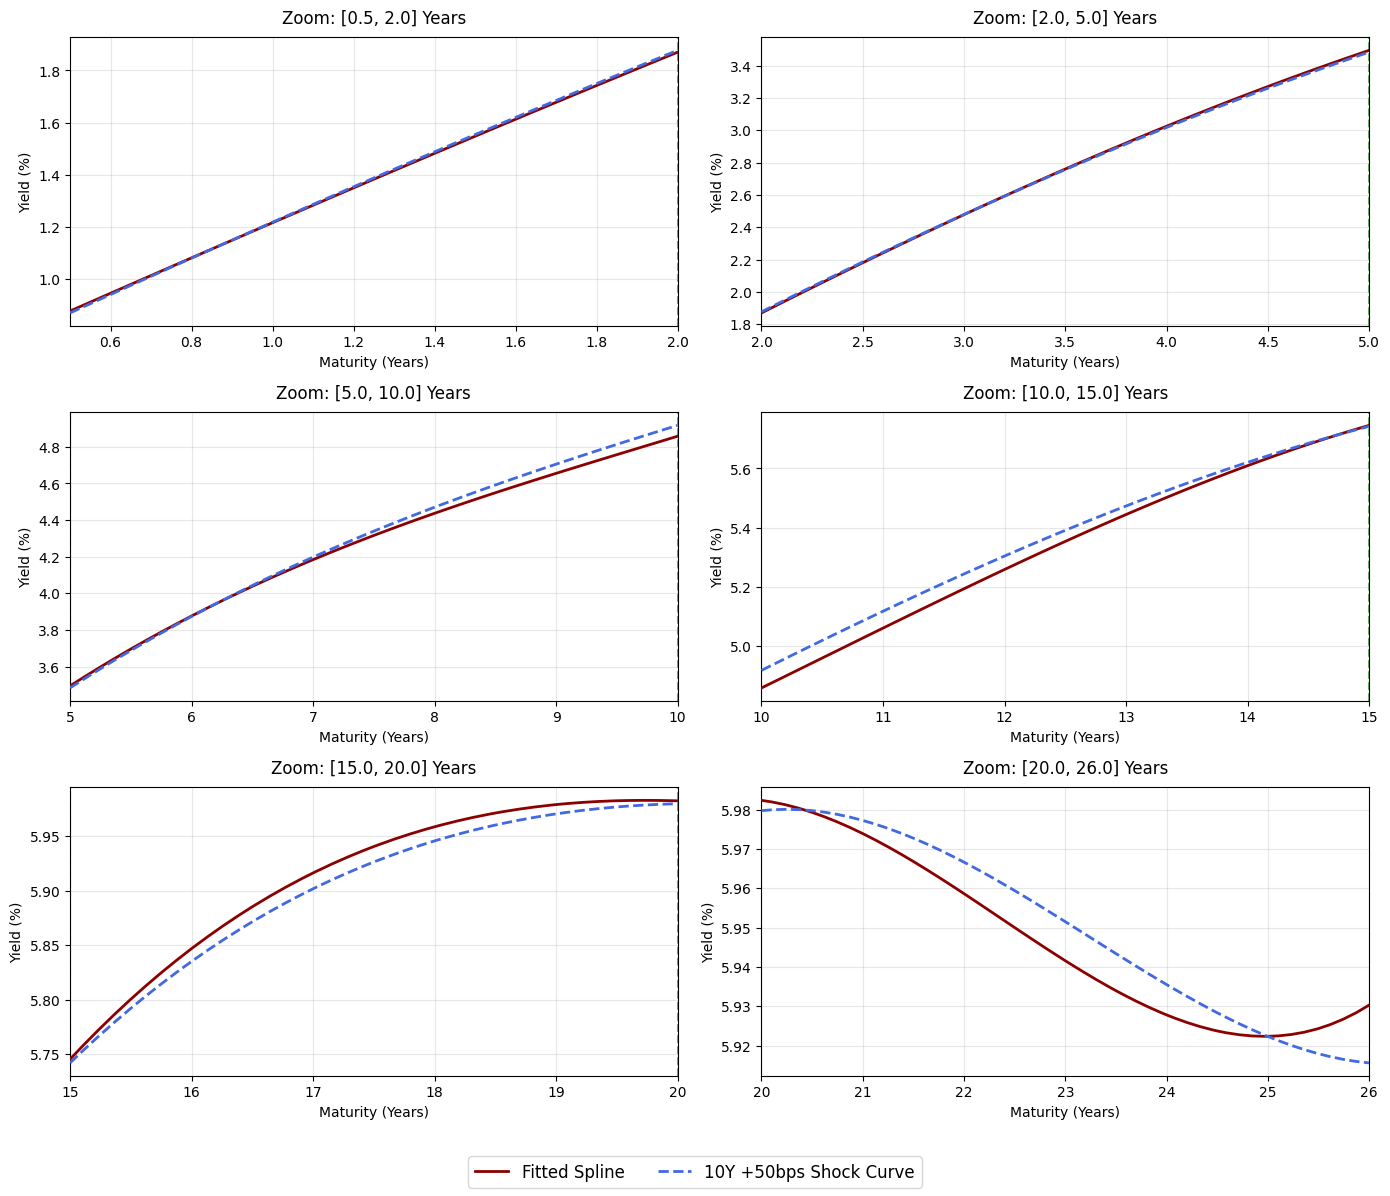

In [ ]:
bounds = [0.5, 2.0, 5.0, 10.0, 15.0, 20.0, 26.0]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for i in range(len(bounds) - 1):
    x_min, x_max = bounds[i], bounds[i+1]
    ax = axes[i]

    mask = (X_smooth_shock.flatten() >= x_min) & (X_smooth_shock.flatten() <= x_max)
    xs = X_smooth_shock[mask]
    ys1 = (Y_smooth_5_knots)[mask]
    ys2 = (Y_smooth_shock)[mask]

    ax.plot(xs, ys1, color='darkred', linewidth=2, label='Fitted Spline', zorder=3)

    ax.plot(xs, ys2, color='royalblue', linewidth=2, linestyle='--',
            label='10Y +50bps Shock Curve', zorder=3)

    for knot in custom_knots_5_knots.flatten():
        if x_min <= knot <= x_max:
            ax.axvline(x=knot, color='green', linestyle='--', alpha=0.6, linewidth=1.5, zorder=1)

    ax.set_xlim(x_min, x_max)

    ax.set_xlabel('Maturity (Years)', fontsize=10)
    ax.set_ylabel('Yield (%)', fontsize=10)
    ax.set_title(f'Zoom: [{x_min}, {x_max}] Years', fontsize=12, pad=10)
    ax.grid(True, alpha=0.3)


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

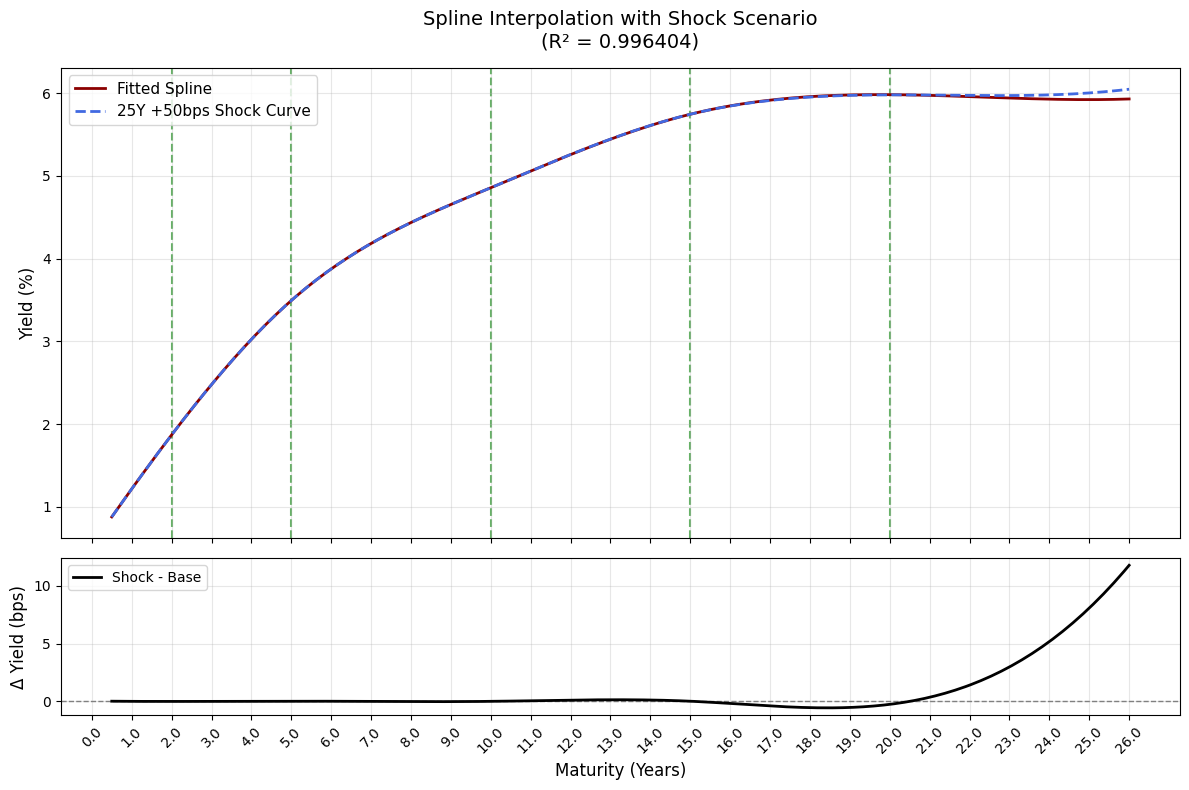

In [ ]:
year_test = 25

data_shoc_test = pd.DataFrame(columns=data.columns, data=data)
old_rate = data_shoc_test.loc[data_shoc_test['Maturity (years)'] == year_test, 'Zero Coupon Yields (%)'].values
new_rate = old_rate + bump

data_shoc_test.loc[data_shoc_test['Maturity (years)'] == year_test, 'Zero Coupon Yields (%)'] = new_rate

X_data_test = data_shoc_test['Maturity (years)'].to_numpy()
Y_data_test = data_shoc_test['Zero Coupon Yields (%)'].to_numpy()

X_smooth_5_knots_test, Y_data_shock_test, r2_test = cubic_spline(X_data_test, Y_data_test, custom_knots_5_knots)
diff_spline_shock_test = Y_data_shock_test - Y_smooth_5_knots

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios':[3,1]})

ax1.plot(X_smooth_5_knots, Y_smooth_5_knots, color='darkred', linewidth=2, label='Fitted Spline', zorder=3)
ax1.plot(X_smooth_5_knots_test.flatten(), Y_data_shock_test, color='royalblue', linewidth=2, linestyle='--',
         label=f'{year_test}Y +50bps Shock Curve', zorder=3)

for knot in custom_knots_5_knots.flatten():
    ax1.axvline(x=knot, color='green', linestyle='--', alpha=0.6, linewidth=1.5, zorder=1)

ax1.set_ylabel('Yield (%)', fontsize=12)
ax1.set_title(f'Spline Interpolation with Shock Scenario\n(R² = {r2_test:.6f})', fontsize=14, pad=15)
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(X_smooth_5_knots_test.flatten(), diff_spline_shock_test * 100, color='black', linewidth=2, label='Shock - Base', zorder=3)
ax2.axhline(0, color='gray', linewidth=1, linestyle='--')  # ligne de référence zéro

ax2.set_xlabel('Maturity (Years)', fontsize=12)
ax2.set_ylabel('Δ Yield (bps)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left', fontsize=10)

int_xticks = np.arange(np.floor(min(X_data)), np.ceil(max(X_data)) + 1, 1)
ax2.set_xticks(int_xticks)
ax2.set_xticklabels(int_xticks, rotation=45)

plt.tight_layout()
plt.show()

<font color='lightgreen' size=5>4.2: Assume you own a 1 million $ portfolio that is equally invested in all bonds.  What is the 
KRD of your portfolio to this scenario? Describe your approach to estimating this exposure.   </font>

In [102]:
# Get the value for different market maturity
df_spline_at_mkt_shock = np.interp(mats_mkt, X_smooth_shock_ravel, df_spline_shock)

# Equally weighted portfolio
initial_portfolio = np.full(shape=len(mats_mkt), fill_value=1_000_000/len(mats_mkt), dtype='float64')

# Calculating Price of different bond with the fitted spline without shock
price = cashflows @ df_mkt

# Units held at first (assuming that we can only hold an entire bond)
units_held = initial_portfolio / price
initial_portfolio_value = np.sum(initial_portfolio)

# Calculating Price of different bond with the fitted spline with shock
price_spline_shock = cashflows @ df_spline_at_mkt_shock

# Compute the difference between the new and the old one
price_change = price_spline_shock - price
price_change_relative = (price_spline_shock - price) / price * 100

# Impact on the PnL of the bump on our equally weighted portfolio
pnl_impact_per_bond = units_held * price_change
final_portfolio = initial_portfolio + pnl_impact_per_bond

# Impact on the whole portfolio
pnl_impact = np.sum(pnl_impact_per_bond)
KDR_impact = pnl_impact/bump_bp
final_portfolio_value = initial_portfolio_value + pnl_impact

In [103]:
# Print the results
print(f"Initial Portfolio Value: {initial_portfolio_value:,.2f}")
print(f"PnL Impact from Shock: {pnl_impact:,.2f}")
print(f"Final Portfolio Value After Shock: {final_portfolio_value:,.2f}")

Initial Portfolio Value: 1,000,000.00
PnL Impact from Shock: -1,094.52
Final Portfolio Value After Shock: 998,905.48


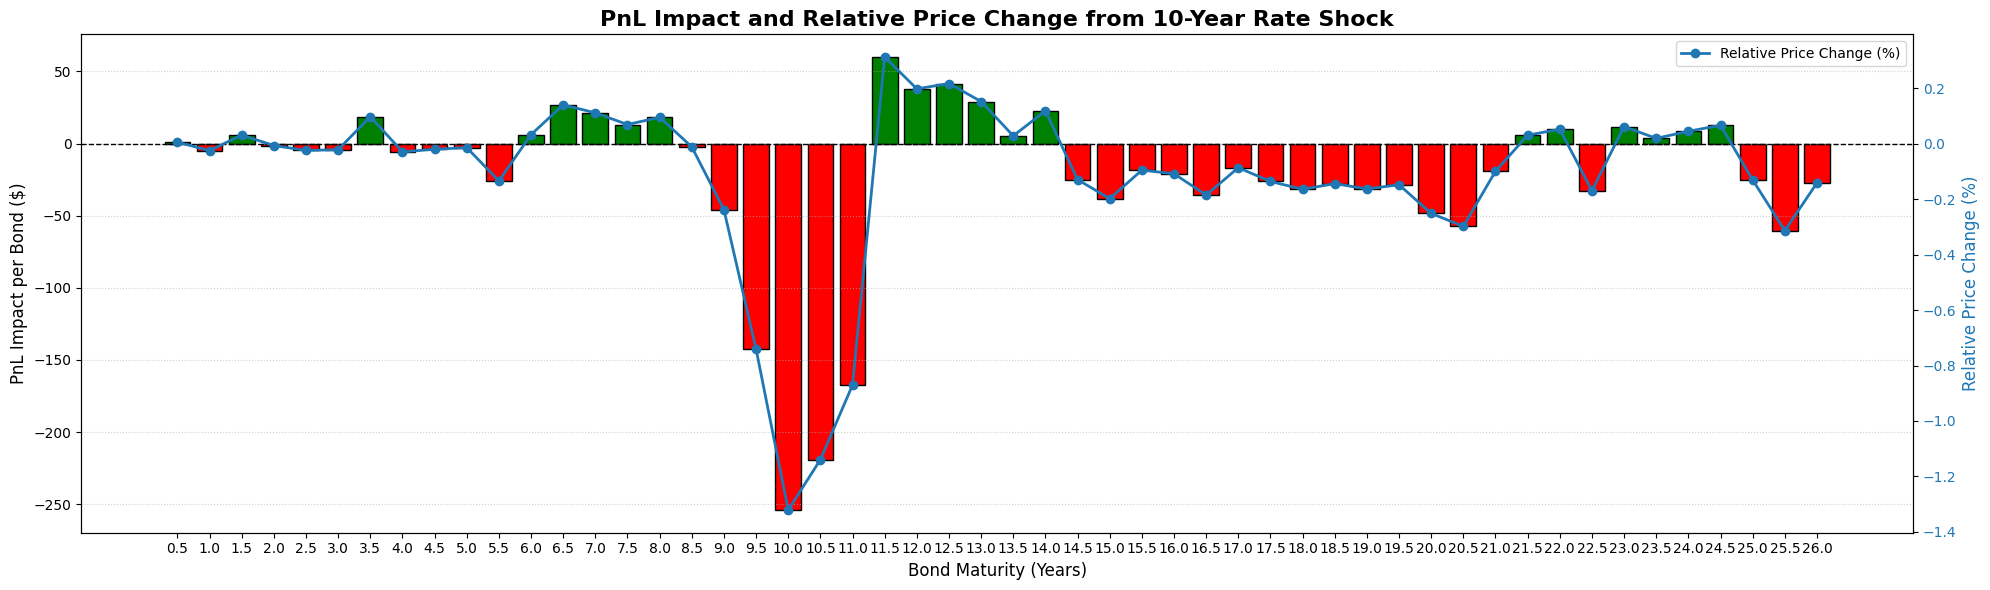

In [104]:
fig, ax1 = plt.subplots(figsize=(20, 6))

# Bar plot: PnL impact per bond
colors = ['green' if val >= 0 else 'red' for val in pnl_impact_per_bond]
bars = ax1.bar(mats_mkt, pnl_impact_per_bond, width=0.4, color=colors, edgecolor='black')
ax1.axhline(0, color='black', linestyle='--', linewidth=1)

ax1.set_xlabel("Bond Maturity (Years)", fontsize=12)
ax1.set_ylabel("PnL Impact per Bond ($)", fontsize=12)
ax1.tick_params(axis='y')
ax1.set_xticks(mats_mkt)
ax1.grid(axis='y', linestyle=':', alpha=0.6)

# Secondary axis: Relative price change (%)
ax2 = ax1.twinx()
ax2.plot(mats_mkt, price_change_relative, color='tab:blue', marker='o', linewidth=2, label='Relative Price Change (%)')
ax2.set_ylabel("Relative Price Change (%)", fontsize=12, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Title and layout
plt.title("PnL Impact and Relative Price Change from 10-Year Rate Shock", fontsize=16, fontweight='bold')
fig.tight_layout()

# Legend for line plot
ax2.legend(loc='upper right')

plt.show()


<font color='lightgreen' size=5>4.3: Estimate  and  plot  the  KRDs  of  your  portfolio  for all  maturities,  when applying  the  same 
shock individually to all zero-coupon yields. Plot and interpret the results.   </font>

In [105]:
bump_bp = 50
bump = bump_bp / 1e2 # Instead of 1e4 because i'm using % values

data_shock_copy = data.__copy__()

X_data_all = data_shock_copy['Maturity (years)'].to_numpy().reshape(-1).copy()
Y_data_all = data_shock_copy['Zero Coupon Yields (%)'].to_numpy().reshape(-1).copy()

In [106]:
spline_shock_kdr = []

for i in range(len(Y_data_all)):

    Y_bumped = Y_data_all.copy()            # writeable copy per node
    Y_bumped[i] += bump                     # +50 bp to the i-th zero rate (in % terms)

    X_s, Y_s, r2 = cubic_spline(X_data_all, Y_bumped, custom_knots_5_knots)

    X_s_ravel = X_s.ravel()
    Y_s_at_mkt = np.interp(mats_mkt, X_s_ravel.ravel(), Y_s)

    # To compute quicker, we use a function that i have defined
    bond_price_s = calculate_bond_price(Y_s_at_mkt, coupon_frequency, mats_mkt, cashflows, numeric=False)
    price_change_s = bond_price_s - price

    # Impact on the PnL of the bump on our equally weighted portfolio
    pnl_impact_per_bond_s = units_held * price_change_s
    pnl_impact_s = np.sum(pnl_impact_per_bond_s)
    KDR_s = pnl_impact_s / bump_bp

    spline_shock_kdr.append(np.round(KDR_s, 2))

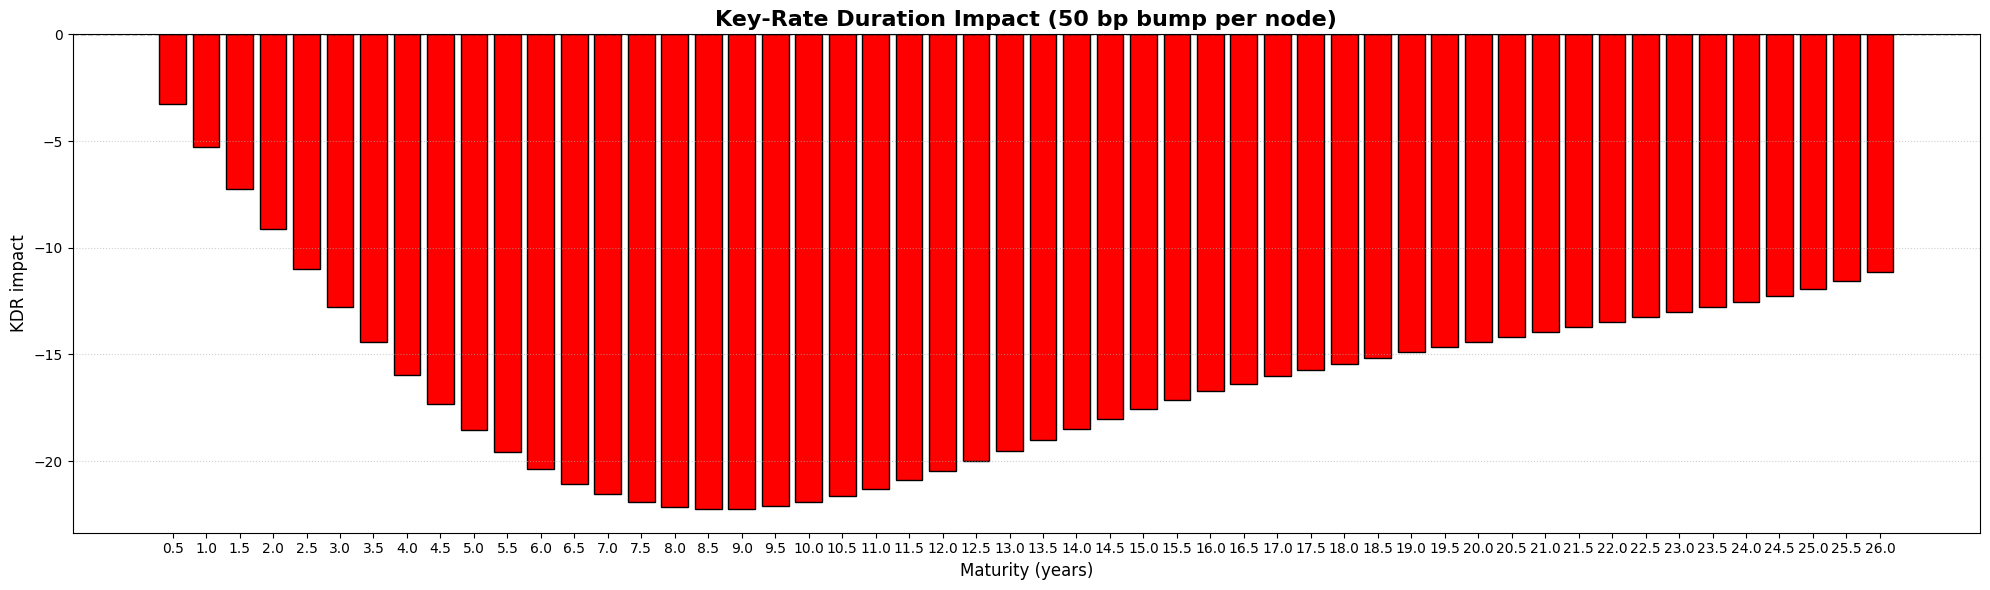

In [107]:
fig, ax1 = plt.subplots(figsize=(20, 6))

# Bar plot: PnL impact per bond
bars = ax1.bar(mats_mkt, spline_shock_kdr, width=0.4, color='red', edgecolor='black')
ax1.axhline(0, color='black', linestyle='--', linewidth=1)

ax1.set_xlabel("Maturity (years)", fontsize=12)
ax1.set_ylabel("KDR impact", fontsize=12)
ax1.tick_params(axis='y')
ax1.set_xticks(mats_mkt)
ax1.grid(axis='y', linestyle=':', alpha=0.6)

# Title and layout
plt.title("Key-Rate Duration Impact (50 bp bump per node)", fontsize=16, fontweight='bold')
fig.tight_layout()
ax2.legend(loc='upper right')

plt.show()


<font color='red' size=8>QUESTION 5 - PORTFOLIO STRATEGY</font>

<font color='lightgreen' size=5>5.1: You expect the bootstrapped zero-coupon curve from Q1.2 to steepen according to the 
following function, where 𝜀 is a random noise and 𝑇̅ is the average bond maturity in your 
sample: 

$$
y_{\text{steepen}}(T) = y_T + \left( \frac{T - \bar{T}}{\bar{T}} \times 0.0050 \right) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 0.0025)
$$


Plot the new curve according to your expectations against the bootstrapped zero-coupon. 
Split the deterministic component of your expectation from the stochastic one originating 
from the random noise 𝜀 term.   </font>

In [108]:
np.random.seed(42)

# Step 1: Deterministic component of the steepening
average_maturity = np.mean(maturities_years)
y_steepen_deterministic = zero_rates + ( ( (maturities_years - average_maturity) / average_maturity ) * 0.0050 )

# Step 2: Simulate stochastic component (Used the Variance because the noice was too important)
e = np.random.normal(loc=0, scale=0.0025, size=(len(maturities_years)))

# Step 3: Total steepened curves (matrix of simulations)
y_steepen_simulated = y_steepen_deterministic + e

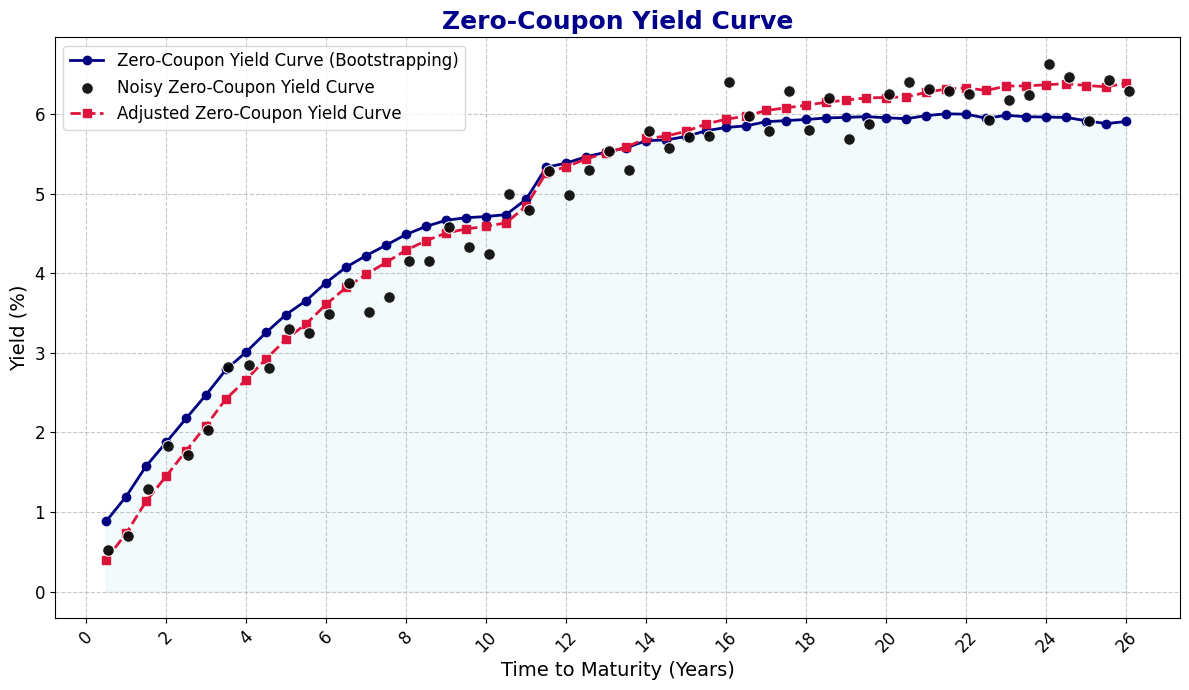

In [ ]:
plt.figure(figsize=(12,7))

plt.plot(
    data["Maturity (years)"],
    data["Zero Coupon Yields (%)"],
    marker="o",
    linewidth=2.0,
    markersize=6,
    color="navy",
    zorder=2,
    label="Zero-Coupon Yield Curve (Bootstrapping)"
)

x = data["Maturity (years)"].to_numpy()
x_jitter = x + 0.06

plt.scatter(
    x_jitter,
    y_steepen_simulated * 100,
    s=70,                 
    alpha=0.9,            
    edgecolors="white",  
    linewidths=0.8,
    zorder=5,             
    label="Noisy Zero-Coupon Yield Curve",
    color='black',
    marker="o"
)

plt.plot(
    data["Maturity (years)"],
    y_steepen_deterministic * 100,
    marker="s",
    linewidth=2.0,
    markersize=6,
    color="crimson",
    linestyle="--",
    zorder=3,
    label="Adjusted Zero-Coupon Yield Curve"
)

plt.fill_between(
    data["Maturity (years)"],
    data["Zero Coupon Yields (%)"],
    alpha=0.10,
    color="skyblue",
    zorder=1
)

plt.title("Zero-Coupon Yield Curve", fontsize=18, fontweight="bold", color="darkblue")
plt.xlabel("Time to Maturity (Years)", fontsize=14)
plt.ylabel("Yield (%)", fontsize=14)

plt.grid(True, linestyle="--", alpha=0.7)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

<font color='lightgreen' size=5>Q5.2: Re-estimate  the  discount function  using  the  Nelson-Siegel-Svensson  methodology, applied in  Q3.1.  Value  all  coupon  paying bonds  accordingly and  identify  the  cheap and 
expensive bonds given their current market prices. Discuss.   </font>

In [110]:
ns_spot_params_step = calibrate_yield_curve(
    maturities_years,
    y_steepen_simulated)

# Generate curves for plotting
tau_plot_step = np.linspace(maturities_years.min(), maturities_years.max(), 500)

# Fitted spot curve (Nelson-Siegel-Svensson)
fitted_spot_ns_step = yield_curve_model(
    tau_plot_step, 
    ns_spot_params_step['beta0'], 
    ns_spot_params_step['beta1'], 
    ns_spot_params_step['beta2'],
    ns_spot_params_step['beta3'],
    ns_spot_params_step['lambda1'],
    ns_spot_params_step['lambda2']
    )

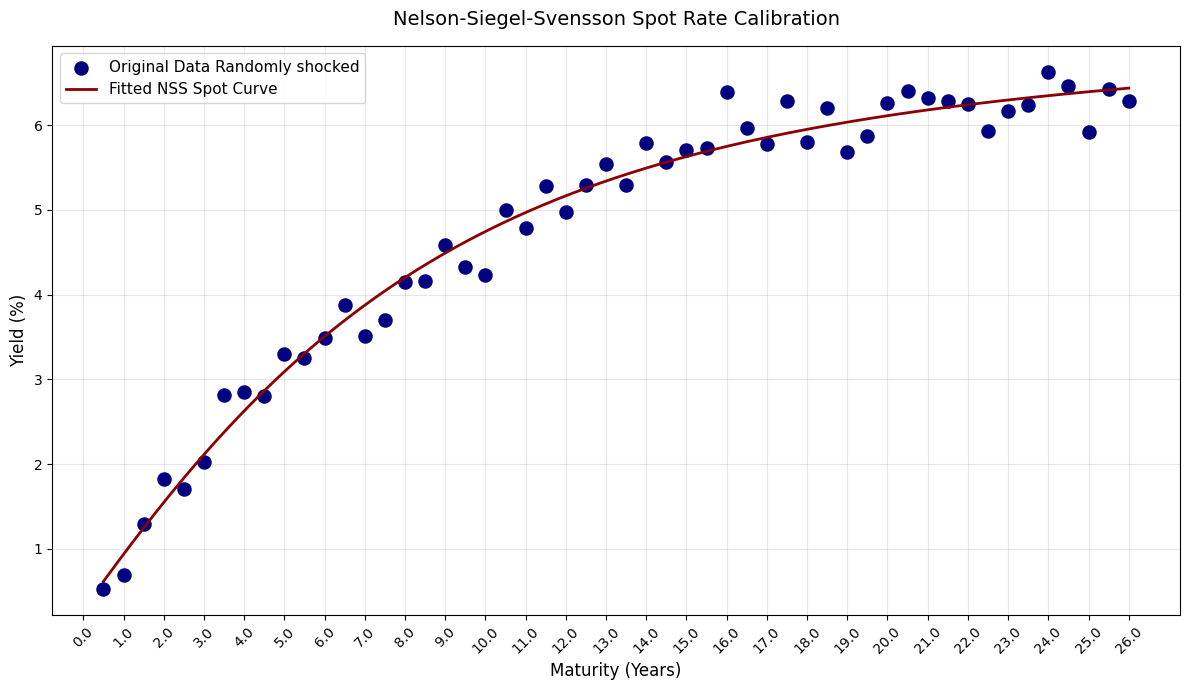

In [ ]:
plt.figure(figsize=(12, 7))
ax = plt.gca()

ax.scatter(
    data['Maturity (years)'], 
    y_steepen_simulated * 100, 
    color="navy", s=80, zorder=2,
    label="Original Data Randomly shocked", linewidth=1.5
)

ax.plot(
    tau_plot, fitted_spot_ns_step * 100,
    color="darkred", linewidth=2, zorder=3,
    label="Fitted NSS Spot Curve"
)

ax.set_xlabel("Maturity (Years)", fontsize=12)
ax.set_ylabel("Yield (%)", fontsize=12)
ax.set_title("Nelson-Siegel-Svensson Spot Rate Calibration", fontsize=14, pad=15)
ax.legend(loc="upper left", fontsize=11)
ax.grid(True, alpha=0.3)

int_xticks = np.arange(
    np.floor(data['Maturity (years)'].min()), 
    np.ceil(data['Maturity (years)'].max()) + 1, 1
)
ax.set_xticks(int_xticks)
ax.set_xticklabels(int_xticks, rotation=45)

plt.tight_layout()
plt.show()

In [112]:
# Calculating the estimated discount factor
df_NSS_step = 1.0 / (1.0 + fitted_spot_ns_step/coupon_frequency) ** (tau_plot_step * 2)

df_NSS_at_mkt_step = np.interp(mats_mkt, tau_plot_step, df_NSS_step)
diff_df_NSS_step = df_mkt - df_NSS_at_mkt_step

# Compute the price of bonds with the estimated NSS when expecting a steepening of the curve
bond_price_NSS_step = cashflows @ df_NSS_at_mkt_step
bond_value = data.select(pl.col('Current Price')).to_numpy().reshape(-1)
diff_bond_price_step = bond_price_NSS_step - bond_value

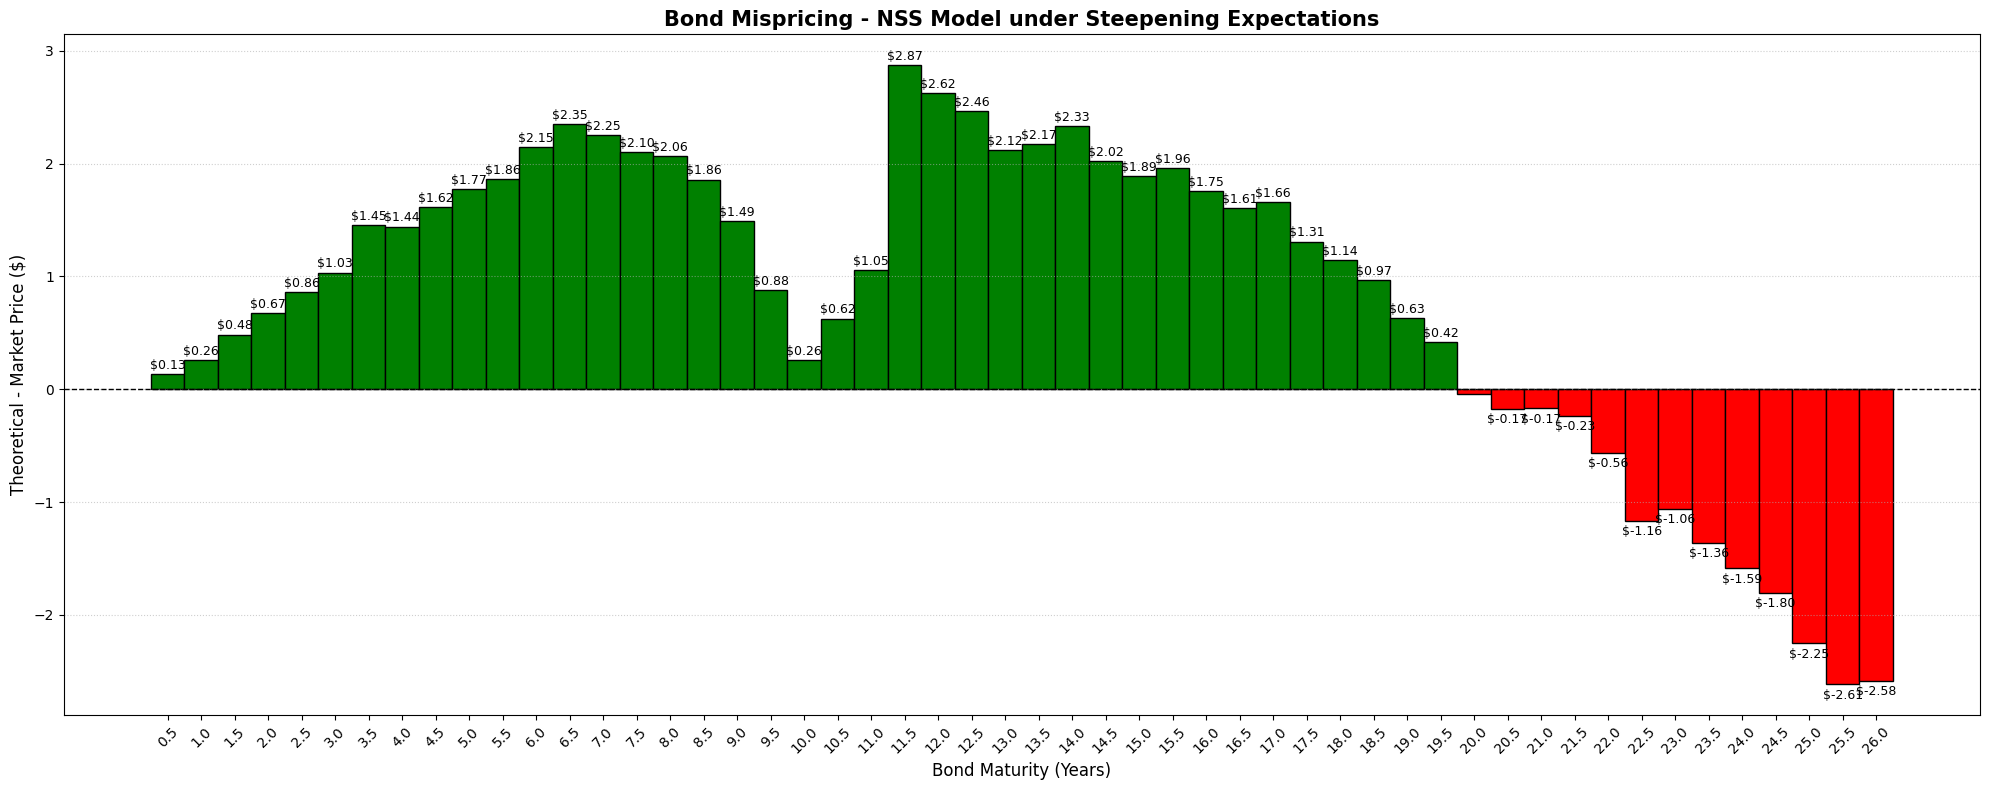

In [113]:
# Determine colors: green = underpriced (cheap), red = overpriced (expensive)
colors = ['green' if x > 0 else 'red' for x in diff_bond_price_step]

# Create figure
plt.figure(figsize=(20, 8))

# Plot bar chart of price differences
bars = plt.bar(mats_mkt, diff_bond_price_step, color=colors, edgecolor='black', width=0.5)

# Add zero line
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Label each bar with value (optional if too many bonds)
for i, bar in enumerate(bars):
    height = bar.get_height()
    if abs(height) > 0.1:  # show only significant changes
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + (0.02 if height > 0 else -0.04),
            f"${height:.2f}",
            ha='center',
            va='bottom' if height > 0 else 'top',
            fontsize=9,
            color='black'
        )

# Labels and title
plt.title("Bond Mispricing - NSS Model under Steepening Expectations", fontsize=15, weight='bold')
plt.xlabel("Bond Maturity (Years)", fontsize=12)
plt.ylabel("Theoretical - Market Price ($)", fontsize=12)

# Grid
plt.grid(axis='y', linestyle=':', alpha=0.6)

# Ticks
plt.xticks(mats_mkt, rotation=45)
plt.tight_layout()

plt.show()


<font color='lightgreen' size=5>Q5.3: Propose  a  diversified  zero-cost  long-short  portfolio  strategy  that  aims  at  harvesting  the 
mispricing identified in the previous questions. Assume your initial wealth is 100$ and your 
financing  costs  are  null.  How  much  should  you  invest  in  which  bonds?  What  is  your 
expected return?   </font>

In [114]:
def duration_and_modified_duration(t:np.array, cd:np.array, df:np.array, y:np.array, freq:np.array, prices:np.array) -> np.array:
    """
    Return:
        mac: Duration of coupon bond,
        mod: Modified Duration of coupon bond
    """
    mac = np.sum(t * df * cd, axis=1) / prices
    mod = mac / (1.0 + y / freq)

    return mac, mod

In [115]:
duration, modified_duration = duration_and_modified_duration(maturities_years, cashflows, df_mkt, zero_rates, coupon_frequency, bond_value)
market_duration = np.mean(modified_duration)
delta_y_curve = y_steepen_simulated - zero_rates
alpha = - modified_duration * bond_value * delta_y_curve
wealth = 100

# 1) Optimization setup

n_bonds = len(bond_value)
weights  = cp.Variable(n_bonds, nonneg=False) # allow long/short
selected = cp.Variable(n_bonds, boolean=True) 
portfolio_duration_expr = cp.sum(cp.multiply(modified_duration, weights))

MIN_POSITION = -0.05
MAX_POSITION = 0.05
leverage_cap = 2.0   # leverage cap, sum |w| <= 200%

# Dollar exposure per bond
dollar_exposure = cp.multiply(bond_value, weights)

# Total long and short dollar exposure
long_value  = cp.sum(cp.pos(dollar_exposure))      # sum of positive exposures
short_value = cp.sum(cp.pos(-dollar_exposure))     # sum of absolute negatives

objective = cp.Maximize(alpha @ weights)

constraints = [

    long_value  <= wealth,
    short_value <= wealth,

    weights >= MIN_POSITION * selected,
    weights <= MAX_POSITION * selected,
    selected >= 0, selected <= 1,

    # zero-cost (price-weighted)
    cp.sum(cp.multiply(bond_value, weights)) == 0,

    # gross leverage
    cp.sum(cp.abs(weights)) <= leverage_cap,

    # duration upper/lower bound
    portfolio_duration_expr <= market_duration,
    portfolio_duration_expr >= -market_duration

]

problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.SCIP, verbose=False)

# solution cleanup
optimal_weights = weights.value; tol = 1e-10
optimal_weights[np.abs(optimal_weights) < tol] = 0.0

# 2) Key metrics and diagnostics

pnl_exp = alpha @ optimal_weights
zero_cost = bond_value @ optimal_weights
gross = np.sum(np.abs(optimal_weights))
duration_portfolio = modified_duration @ optimal_weights
held = optimal_weights != 0.0
n_hold = np.sum(held)
n_long = np.sum(optimal_weights > 0)
n_short = np.sum(optimal_weights < 0)
min_pos = np.min(optimal_weights[held]) if n_hold else 0.0
max_pos = np.max(optimal_weights[held]) if n_hold else 0.0
sum_dollar_long = np.sum( (bond_value * optimal_weights)[bond_value * optimal_weights > 0] )
sum_dollar_short = np.sum( (bond_value * optimal_weights)[bond_value * optimal_weights < 0] )

print(f"Status             | {problem.status}")
print(f"Scenario P&L max   | {pnl_exp/wealth * 100:,.4f} %")
print(f"Zero-cost check    | {zero_cost:.4g}")
print(f"Total long ($)     | {sum_dollar_long:.4g} ($)")
print(f"Total short ($)    | {sum_dollar_short:.4g} ($)")
print(f"Gross exposure     | {gross*100:.2f} % (cap {leverage_cap * 100} %)")
print(f"# of holdings      | {n_hold} (long: {n_long} / short: {n_short})")
print(f"Min/Max position   | {min_pos:.2%} / {max_pos:.2%}")
print(f"Portfolio duration | {duration_portfolio:.6f} (<=- market |{market_duration:.6f}|)")



Status             | optimal
Scenario P&L max   | 6.1402 %
Zero-cost check    | 1.954e-14
Total long ($)     | 100 ($)
Total short ($)    | -100 ($)
Gross exposure     | 167.95 % (cap 200.0 %)
# of holdings      | 35 (long: 18 / short: 17)
Min/Max position   | -5.00% / 5.00%
Portfolio duration | -3.117045 (<=- market |7.956154|)


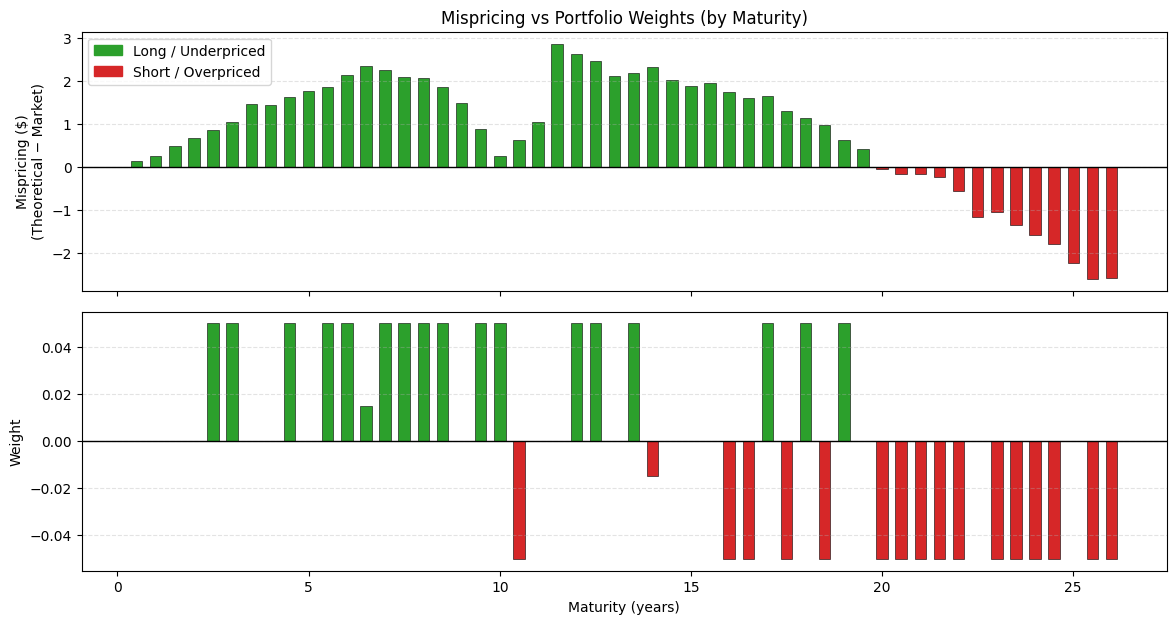

In [ ]:
m = np.asarray(mats_mkt, float)
mis = np.asarray(diff_bond_price_step, float)      
w  = np.asarray(optimal_weights, float)           

idx = np.argsort(m)
m, mis, w = m[idx], mis[idx], w[idx]

width = 0.6 * np.min(np.diff(np.unique(m))) if len(np.unique(m)) > 1 else 0.4

fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True, gridspec_kw=dict(hspace=0.08))

colors_mis = np.where(mis >= 0, 'tab:green', 'tab:red')
axes[0].bar(m, mis, width=width, color=colors_mis, edgecolor='black', linewidth=0.4)
axes[0].axhline(0, color='black', linewidth=1)
axes[0].set_ylabel("Mispricing ($)\n(Theoretical − Market)")
axes[0].set_title("Mispricing vs Portfolio Weights (by Maturity)")
axes[0].grid(True, axis='y', linestyle='--', alpha=0.35)

colors_w = np.where(w >= 0, 'tab:green', 'tab:red')
axes[1].bar(m, w, width=width, color=colors_w, edgecolor='black', linewidth=0.4)
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_xlabel("Maturity (years)")
axes[1].set_ylabel("Weight")
axes[1].grid(True, axis='y', linestyle='--', alpha=0.35)

legend_items = [Patch(color='tab:green', label='Long / Underpriced'),
                Patch(color='tab:red',   label='Short / Overpriced')]
axes[0].legend(handles=legend_items, loc='upper left')

plt.tight_layout()
plt.show()
